
## Chapter 3 [Imaging](Ch3-Imaging.ipynb)


<hr style="height:1px;border-top:4px solid #FF8200" />

# Find Atom Positions with Blob Detector


part of 

## [Analysis of Transmission Electron Microscope Data](_Analysis_of_Transmission_Electron_Microscope_Data.ipynb)



by Gerd Duscher, 2019

Microscopy Facilities<br>
Joint Institute of Advanced Materials<br>
The University of Tennessee, Knoxville

Model based analysis and quantification of data acquired with transmission electron microscopes







## First we import the usual libraries
Please visit the  section for [pyTEMlib](Ch1-Prerequisites.ipynb#TEM_Library) of the [Prerequesites](Ch1-Prerequisites.ipynb) section for information of necessary packages.

In [1]:
# import matplotlib and numpy
#                       use "inline" instead of "notebook" for non-interactive plots
%pylab --no-import-all notebook
%gui qt

# Import libraries from the book

import pyTEMlib
import pyTEMlib.file_tools  as ft     # File input/ output library
import pyTEMlib.image_tools as it

# import packages for pyUSID
import pyUSID as usid
import h5py

# For archiving reasons it is a good idea to print the version numbers out at this point
print('pyUSID version: ',usid.__version__)
print('pyTEM version: ',pyTEMlib.__version__)

__notebook__ = 'CH3-Find_Atoms'
__notebook_version__ = '2019_04_20'


Populating the interactive namespace from numpy and matplotlib
windows
pyUSID version:  0.0.4
pyTEM version:  0.3.2019


## Load an image :
If it is a image stack please do the [Image Registration](CH3-Image_Registration.ipynb) notebook first.

We load an image and we start our calculation log, which we set up as a python dictionary. <br>
Please note that the **open file dialog** might not apear in the foreground!



Log_000 includes analysis: Rigid Registration
Log_001 includes analysis: Non-Rigid Registration
Log_002 includes analysis: Atom Positions
Log_003 includes analysis: atom position refinement


<IPython.core.display.Javascript object>


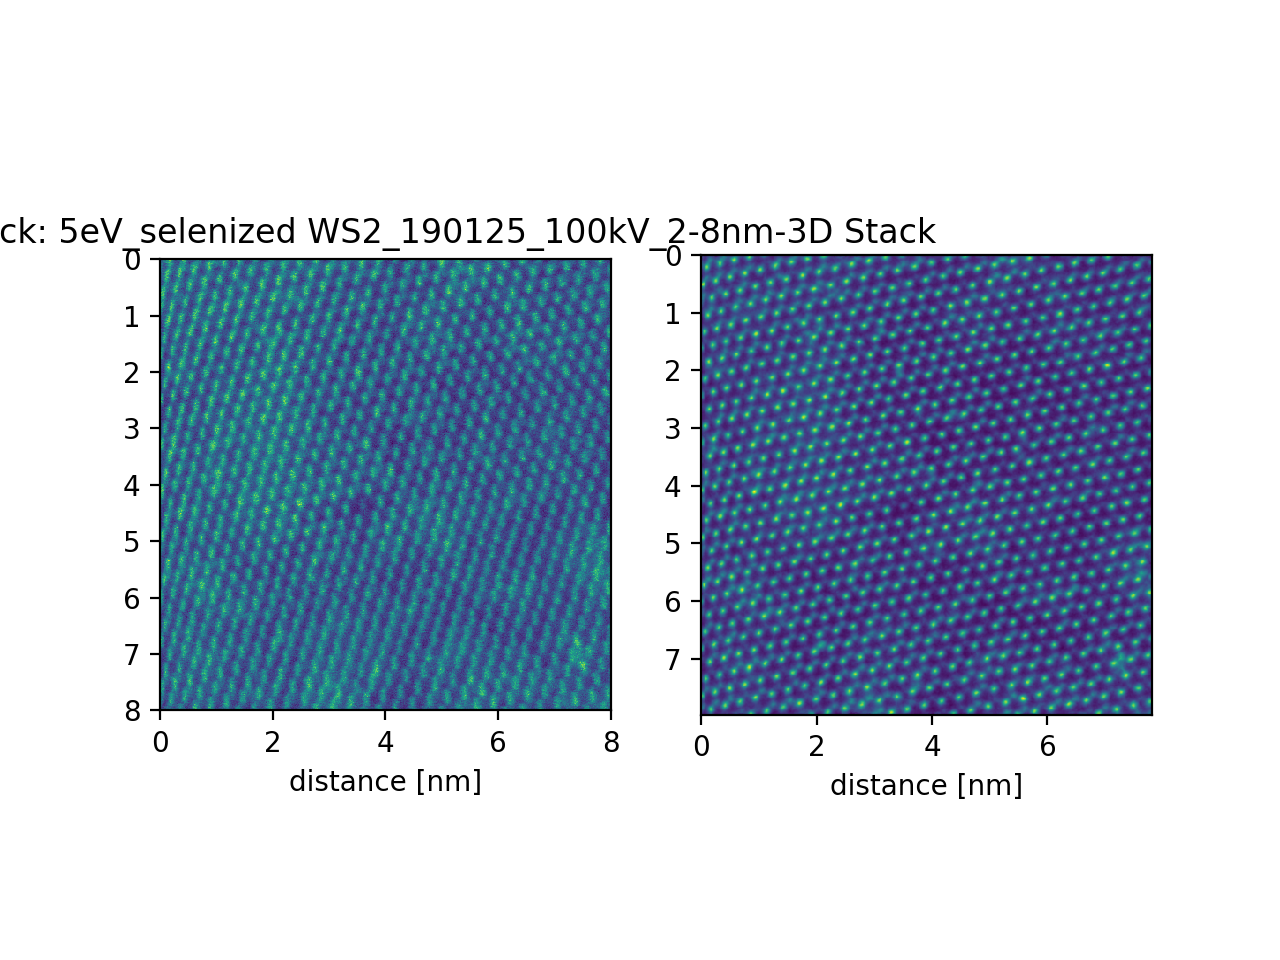

In [4]:
# Load file
#h5_file.close()
h5_file = ft.h5open_file()#os.path.join(current_directory,filename))
current_channel = h5_file['Measurement_000/Channel_000']

log_channel = current_channel
for key in current_channel:
    if 'Log' in key:
        print(f"{key} includes analysis: {current_channel[key]['analysis'][()]}")
        if 'Registration' in current_channel[key]['analysis'][()]:
            log_channel = current_channel[key]


if log_channel == current_channel:
    ft.plt_pyUSID(current_channel)   
    data = log_channel['Raw_Data'][()]
else:
    fig, [ax1,ax2] = plt.subplots(1,2)
    ft.plt_pyUSID(current_channel, ax1)
    ax2.imshow(log_channel['data'][()],origin='upper', extent = log_channel['extent'][()])
    ax2.set_xlabel('distance ['+ log_channel['spatial_units'][()]+']');
    
    data = log_channel['data'][()]


out_tags = {}


# Blob Detection

We use the blob detector of skimage package of scipy to find the atoms.

In [45]:
def find_atoms(im, tags, verbose = False):
    from skimage.feature import  blob_log #blob_dog, blob_doh
    if 'rel_blob_size' not in tags:
        tags['rel_blob_size'] = .4 # between 0 and 1 nromally around 0.5
        tags['source_size'] = 0.06 #in nm gives the size of the atoms or resolution
        tags['nearest_neighbours'] = 7 # up to this number nearest neighbours are evaluated (normally 7)
        tags['threshold'] =  .15 # between 0.01 and 0.1 
        tags['rim_size'] = 2# size of rim in multiples of source size
        
    rel_blob_size = tags['rel_blob_size'] # between 0 and 1 nromally around 0.5
    source_size = tags['source_size']  #in nm gives the size of the atoms
    nearest_neighbours  = tags['nearest_neighbours'] # up to this number nearest neighbours are evaluated (normally 7)
    threshold = tags['threshold']  # between 0.01 and 0.1 
    rim_size = tags['rim_size'] # sizeof rim in multiples of resolution
    pixel_size = tags['pixel_size']
                      
    rim_width = rim_size*source_size/pixel_size
    
    ## Get a noise free image: reduced
    #pixel_size = FOV/im.shape[0]
    reduced_image = it.clean_svd(im,pixel_size=pixel_size,source_size=source_size)

    reduced_image = reduced_image-reduced_image.min()
    reduced_image = reduced_image/reduced_image.max()
    out_tags = {}
    out_tags['reduced_image'] = reduced_image
    patch_size = im.shape[0]-reduced_image.shape[0]
    out_tags['patch_size'] = patch_size
    print(f' Use {patch_size} x {patch_size} pixels for image-patch of atoms')

    # Find atoms    
    thresh = reduced_image.std()*threshold
    blobs = blob_log(np.array(reduced_image), max_sigma=source_size/pixel_size, threshold=thresh)
    plot_image = im[int(patch_size/2):,int(patch_size/2):]

    atoms = []
    from skimage.feature import blob_log
    for blob in blobs:
        y, x, r = blob
        if r > patch_size*rel_blob_size:
            atoms.append([x+patch_size/2,y+patch_size/2,r])

    rim_atoms = []

    for i in range(len(atoms)):
        if (np.array(atoms[i][0:2])<rim_width).any() or (np.array(atoms[i]) > im.shape[0]-rim_width-5).any():
            rim_atoms.append(i)
    rim_atoms=np.unique(rim_atoms)
    mid_atoms_list = np.setdiff1d(np.arange(len(atoms)),rim_atoms)
    
    mid_atoms = np.array(atoms)[mid_atoms_list]
    if verbose:
        print(f'Evaluated {len(mid_atoms)} atom positions, out of {len(atoms)} atoms')
    
    
    out_tags['atoms'] = atoms
    out_tags['mid_atoms'] = mid_atoms
    out_tags['rim_atoms'] = rim_atoms
    out_tags['number_of_atoms'] = len(atoms)
    out_tags['number_of_evaluated_atoms' ]= len(mid_atoms)
    print(f'Evaluated {len(mid_atoms)} atom positions')
    
    return out_tags

The input ...

The source size 100.0 pm is used as measure of atom size which is a patch with diameter 6 pixels  
6
 Use 5 x 5 pixels for image-patch of atoms
Evaluated 1133 atom positions
dict_keys(['reduced_image', 'patch_size', 'atoms', 'mid_atoms', 'rim_atoms', 'number_of_atoms', 'number_of_evaluated_atoms'])


<IPython.core.display.Javascript object>


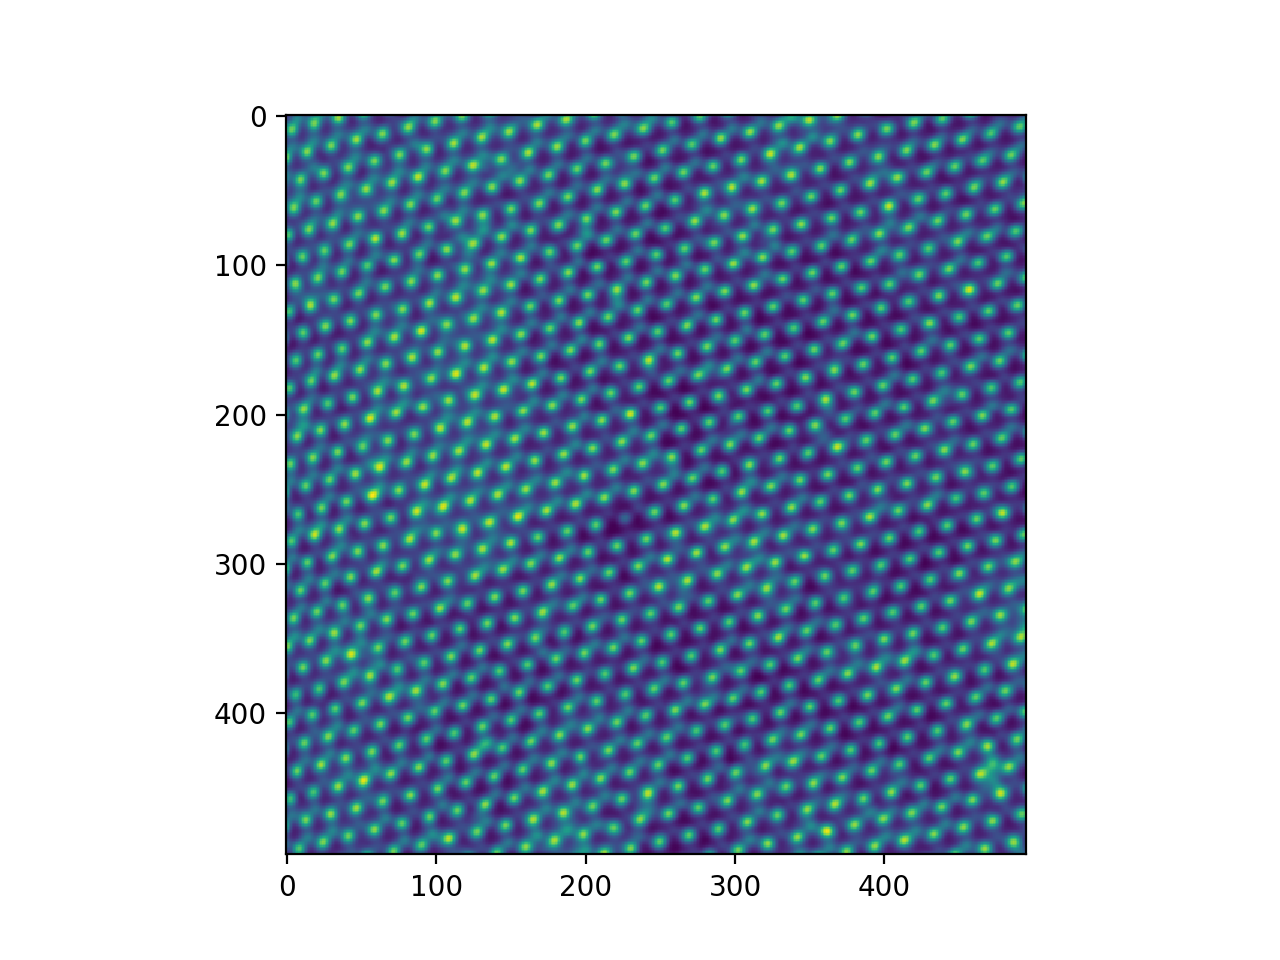

<IPython.core.display.Javascript object>


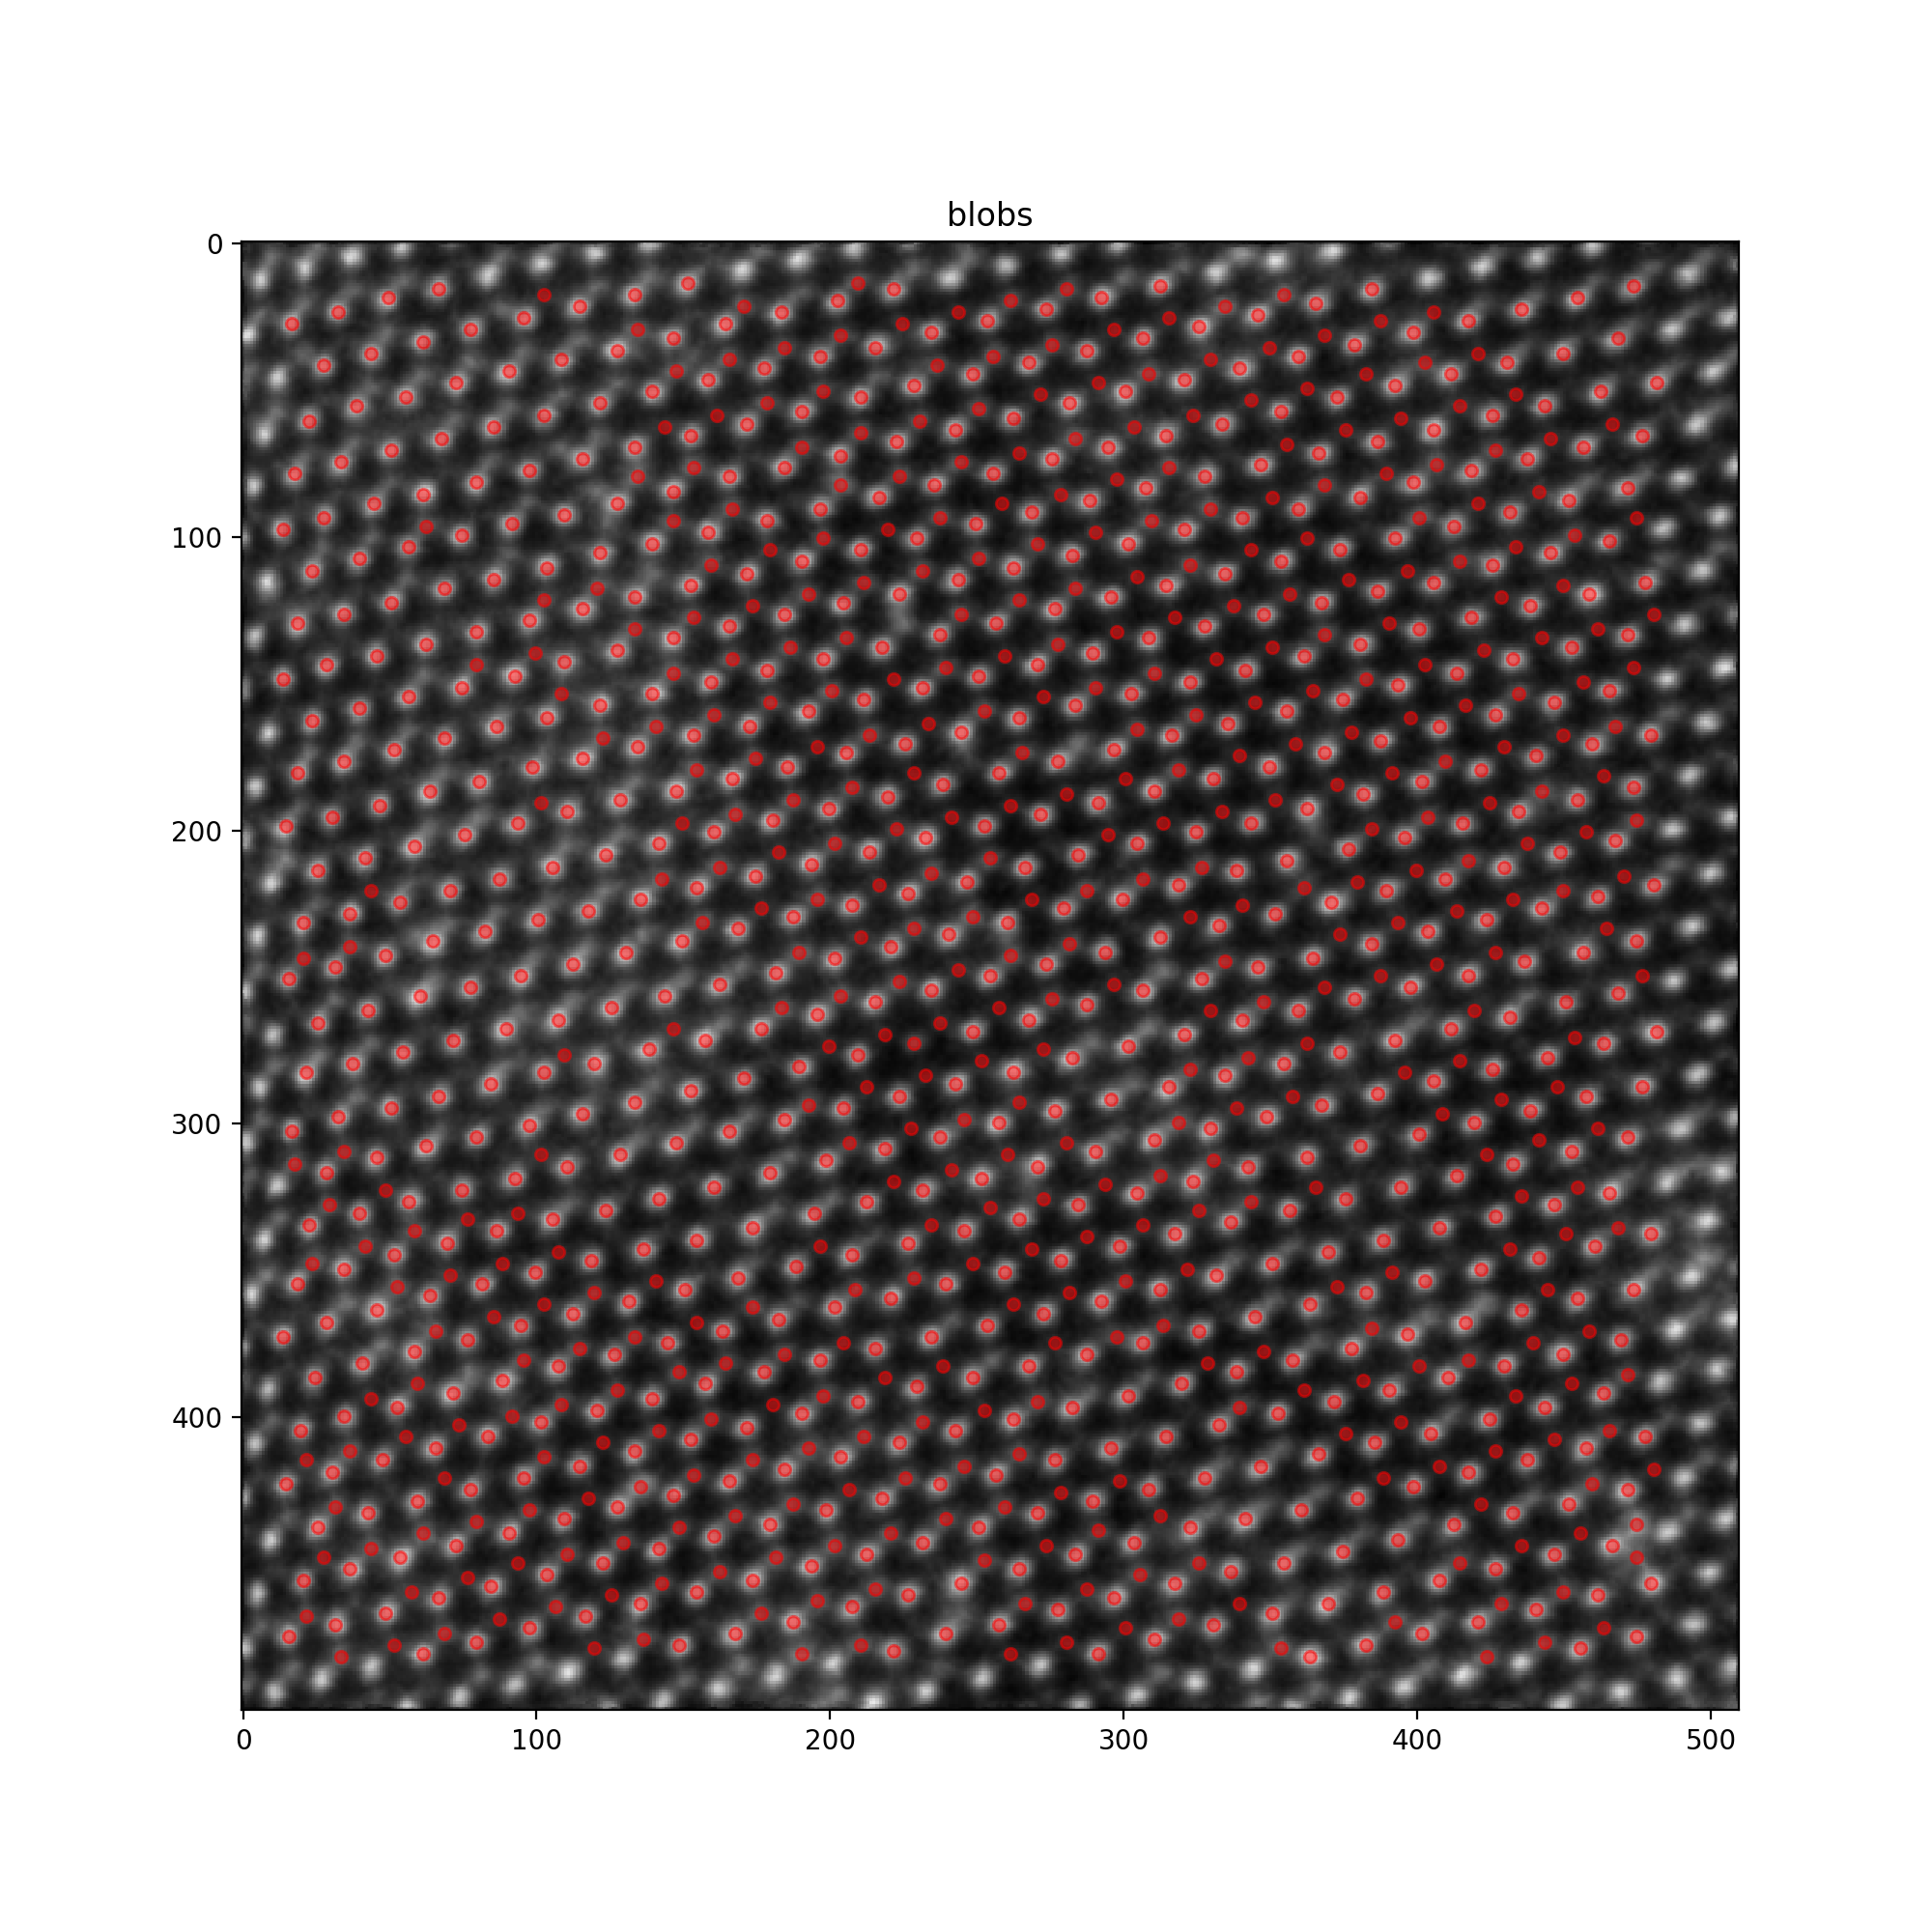

In [54]:

image_size = min(data.shape)
#########
# INPUT #
#########
out_tags  =  {}
out_tags['image'] = data
out_tags['rel_blob_size'] = .1 # between 0 and 1 nromally around 0.5
out_tags['source_size'] = 0.1 #in nm gives the size of the atoms or resolution
out_tags['nearest_neighbours'] = 7 # up to this number nearest neighbours are evaluated (normally 7)
out_tags['threshold'] =  .02 # between 0.01 and 0.1 
out_tags['rim_size'] = 2# size of rim in multiples of source size
out_tags['spatial_scale_x'] = current_channel['spatial_scale_x'][()]
out_tags['spatial_scale_y'] = current_channel['spatial_scale_y'][()]
out_tags['pixel_size'] = current_channel['spatial_scale_x'][()]

print(f"The source size {out_tags['source_size']*1000:.1f} pm is used as measure of atom size which is a patch with diameter {out_tags['source_size']/ out_tags['pixel_size']:.0f} pixels  " )


tags  = find_atoms(data[0:image_size,0:image_size], out_tags)
print(tags.keys())
out_tags.update(tags)

fig1, ax = plt.subplots(1, 2,figsize=(10,10))
ax.set_title("blobs")
plt.imshow(data, interpolation='nearest',cmap='gray')
plt.scatter(out_tags['mid_atoms'][:, 0], out_tags['mid_atoms'][:, 1], c='r', s=20, alpha = .5);

## Log Atom Positions

In [59]:
out_tags['analysis']= 'Atom Positions'
out_tags['notebook']= __notebook__ 
out_tags['notebook_version']= __notebook_version__


out_tags['data'] = data
out_tags['log_channel'] = log_channel.name.split('/')[-1]
out_tags['spatial_origin_x'] = 0.
out_tags['spatial_origin_y'] = 0.
out_tags['spatial_scale_x'] = current_channel['spatial_scale_x'][()]
out_tags['spatial_scale_y'] = current_channel['spatial_scale_y'][()]
out_tags['spatial_size_x'] = data.shape[0]
out_tags['spatial_size_y'] = data.shape[1]
out_tags['spatial_units'] = 'nm'


FOV_x = out_tags['spatial_size_x']* out_tags['spatial_scale_x']
FOV_y = out_tags['spatial_size_y']* out_tags['spatial_scale_y']
out_tags['extent'] = [0,FOV_x,FOV_y, 0]
name = 'Atom finding'
        
log_group = ft.h5_add_Log(current_channel, name)
ft.h5_add_Data2Log(log_group, name, out_tags)

for key in current_channel:
    if 'Log' in key:
        print(f"{key} includes analysis: {current_channel[key]['analysis'][()]}")
        
        log_channel = current_channel[key]

Log_000 includes analysis: Rigid Registration
Log_001 includes analysis: Non-Rigid Registration
Log_002 includes analysis: Atom Positions


# Why and How to Refine Atom Positions

source size is 70 pm
2 [ 3.72388068 -0.10693597 -0.45792529  1.67656317]
Old Atom Position 71, 427
New Atom Position 70.89, 426.54


<IPython.core.display.Javascript object>


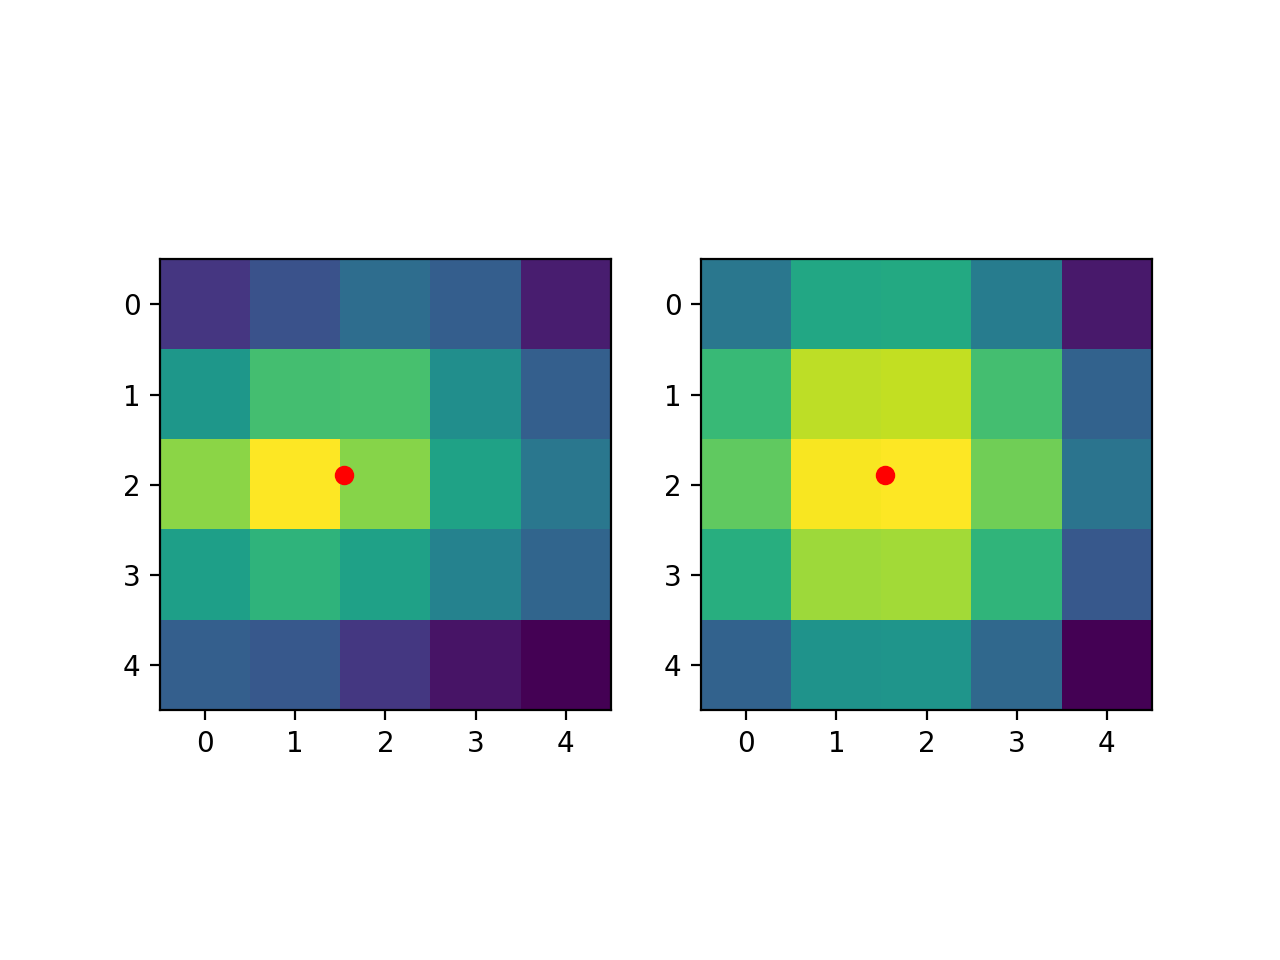

146.0801821975873
36.170208 36.16659882941709


<IPython.core.display.Javascript object>


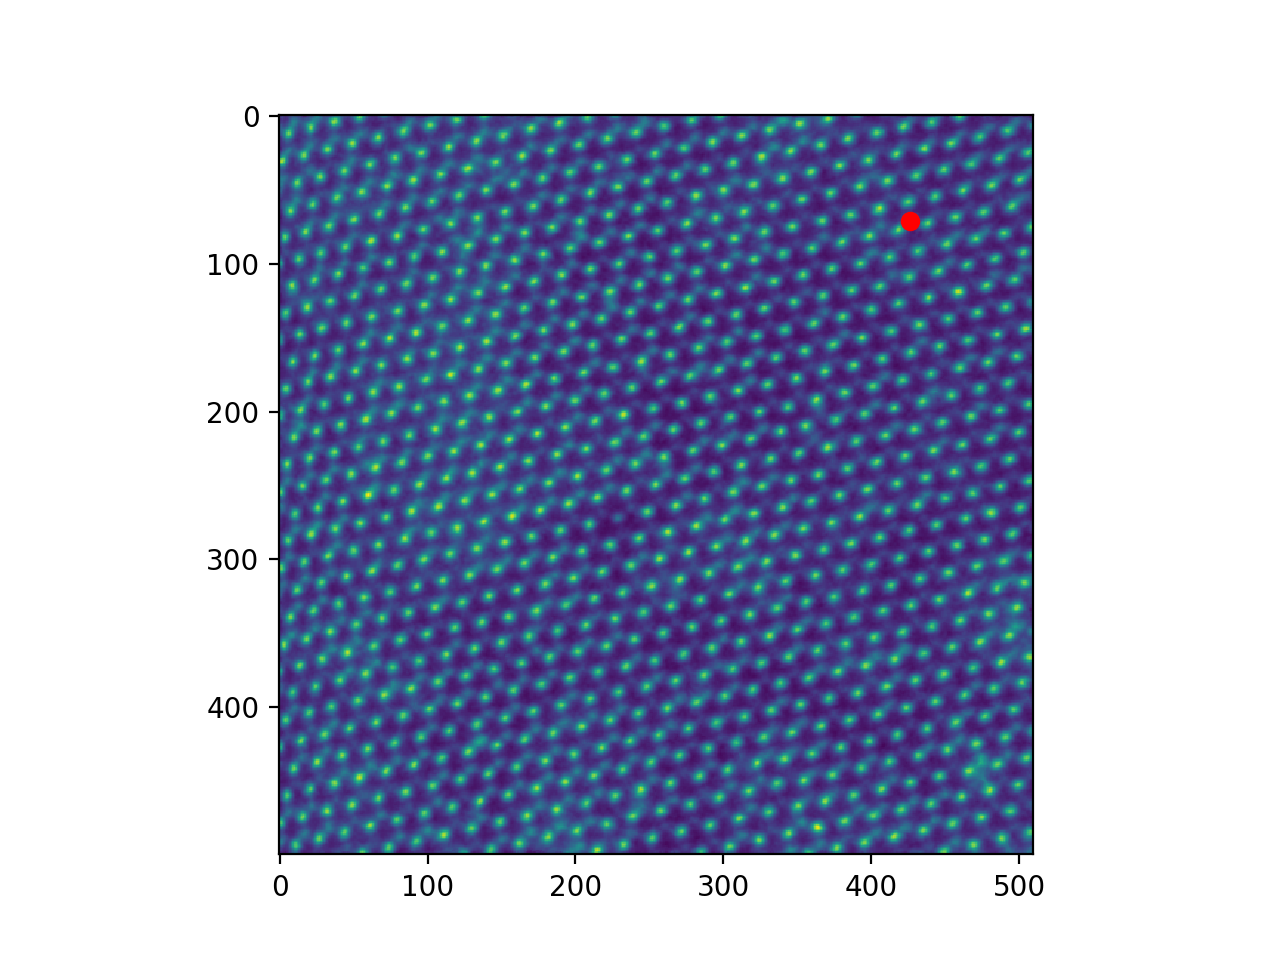

426.5420747147102 70.893064025457


In [13]:
#########
# Input # select which atom to fit and how big of an area we use.
#########

which_atom = i = 997 #select a random atom


## Area of atom is determined by the source_size parameter which is supposed to give us the radius of the atom blob
## If source size is too large, then there are more than one atom in the area to be fitted and stupid things will occur.
log_channel=current_channel['Log_002']
source_size = 0.1 
source_size = log_channel['source_size'][()]*.7
print(f'source size is {source_size*1000:.0f} pm')



## Let's amke a round mask 
radius = int((source_size/ log_channel['spatial_scale_x'][()]/2.+0.5))
pixels = np.linspace(0,2*radius,2*radius+1)-radius
x_mask,y_mask = np.meshgrid(pixels,pixels);
mask = (x_mask**2+y_mask**2) < radius**2 #


## area which contains the atom
atoms = log_channel['mid_atoms'][()]

y,x = atoms[which_atom][0:2]
x = int(x+0.5)
y = int(y+0.5)

area = data[x-radius:x+radius+1,y-radius:y+radius+1]#*mask


from scipy.optimize import leastsq

def Gauss_2D(params, ydata):
    width = int(ydata.shape[0]/2)
    Gauss_width = params[0]
    x0 = params[1]
    y0 = params[2]
    inten = params[3]

    x, y = np.mgrid[-width:width+1, -width:width+1]


    return np.exp(-((x-x0)**2 + (y-y0)**2) /2./ Gauss_width**2)*inten
def Gauss_difference (params,  xdata, ydata):
    #self.img1b.setImage(gauss)
    gauss = Gauss_2D(params, ydata)
    return (ydata - gauss).flatten()

guess  = [radius*2, 0.0, 0.0 , 1]    
pout, res =  leastsq(Gauss_difference, guess, args=(area, area))
print(radius, pout)
new_x = x+pout[1]
new_y = y+pout[2]

print(f'Old Atom Position {x}, {y}')
print(f'New Atom Position {new_x:.2f}, {new_y:.2f}')

fig, [ax1,ax2] = plt.subplots(1,2)
ax1.imshow(area, origin='upper')


gauss = Gauss_2D(pout,area)
Gauss_width = pout[0]
inten = pout[3]
print(inten*2*np.pi*Gauss_width**2)
width = int(area.shape[0]/2)
ax1.scatter(pout[2]+width,pout[1]+width,color='red')

ax2.scatter(pout[2]+width,pout[1]+width,color='red')
ax2.imshow(gauss, origin='upper')

print(area.sum(),gauss.sum())
plt.figure()
plt.imshow(data, origin='upper')
plt.scatter(pout[2]+y,pout[1]+x,color='red')

print(pout[2]+y,pout[1]+x)

## Refine All Atom Positions

In [34]:
from scipy.optimize import leastsq
def atomRefine(image, atoms, tags, maxDist = 2):
    
    rr = int(tags['radius']+0.5) # atom radius
    print('using radius ',rr, 'pixels')
    
    pixels = np.linspace(0,2*rr,2*rr+1)-rr
    x,y = np.meshgrid(pixels,pixels);
    mask = (x**2+y**2) < rr**2 #
    

    def Gauss_2D(params, ydata):
        width = int(ydata.shape[0]/2)
        Gauss_width = params[0]
        x0 = params[1]
        y0 = params[2]
        inten = params[3]

        x, y = np.mgrid[-width:width+1, -width:width+1]


        return np.exp(-((x-x0)**2 + (y-y0)**2) /2./ Gauss_width**2)*inten
    def Gauss_difference (params,  xdata, ydata):
        #self.img1b.setImage(gauss)
        gauss = Gauss_2D(params, ydata)
        return (ydata - gauss).flatten()

    guess  = [radius*2, 0.0, 0.0 , 1]    
    
    #tags['symmetry'] = {}
    sym = {}
    sym['number_of_atoms'] = len(atoms)
    
    volume = []
    position = []
    intensity_area = []
    maximum_area = []
    newatoms = []
    Gauss_width = []
    Gauss_amplitude = []
    Gauss_intensity = []
    
    for i in range(len( atoms)):
        
        y,x = atoms[i][0:2]
        x = int(x)
        y = int(y)
        append = False
        
        
        area = image[x-rr:x+rr+1,y-rr:y+rr+1]
       
        append = False
        
        if (x-rr) < 0 or y-rr <0 or x+rr+1 > image.shape[0] or y+rr+1 > image.shape[1]:
            position.append(-1)
            intensity_area.append(0) 
            maximum_area.append(0)
        else:
            position.append(1)
            intensity_area.append((area*mask).sum() )
            maximum_area.append((area*mask).max())
            
        if tags['MaxInt']>0:
            if area.sum()< tags['MaxInt']:                    
                if area.sum() > tags['MinInt']:
                    append = True
        elif area.sum()> tags['MinInt']:
            append = True
        
        pout = [0,0,0,0]
        if append:
            if (x-rr) < 0 or y-rr <0 or x+rr+1 > image.shape[0] or y+rr+1 > image.shape[1]:
                pass
            else:
                pout, res =  leastsq(Gauss_difference, guess, args=(area, area))
                
            if (abs(pout[1])> maxDist) or (abs(pout[2])> maxDist):
                pout = [0,0,0,0]
    
        volume.append(2* np.pi * pout[3] * pout[0]*pout[0])

        newatoms.append([y+pout[2], x+pout[1]])# ,pout[0],  volume)) #,pout[3]))
        if (all(v == 0 for v in pout)):
            Gauss_intensity.append(0.)
        else:
            Gauss_intensity.append((Gauss_2D(pout, area)*mask).sum() )
        Gauss_width.append(pout[0])
        Gauss_amplitude.append(pout[3])
    
    
    sym['inside'] = position
    sym['intensity_area'] = intensity_area 
    sym['maximum_area'] = maximum_area
    sym['atoms'] = newatoms
    sym['Gauss_width'] = Gauss_width
    sym['Gauss_amplitude'] = Gauss_amplitude
    sym['Gauss_intensity'] = Gauss_intensity
    sym['Gauss_volume'] = volume
    
    return sym

using radius  3 pixels


C:\Users\gduscher\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\minpack.py:436: RuntimeWarning: Number of calls to function has reached maxfev = 1000.
  warnings.warn(errors[info][0], RuntimeWarning)


dict_keys(['number_of_atoms', 'inside', 'intensity_area', 'maximum_area', 'atoms', 'Gauss_width', 'Gauss_amplitude', 'Gauss_intensity', 'Gauss_volume'])


<IPython.core.display.Javascript object>


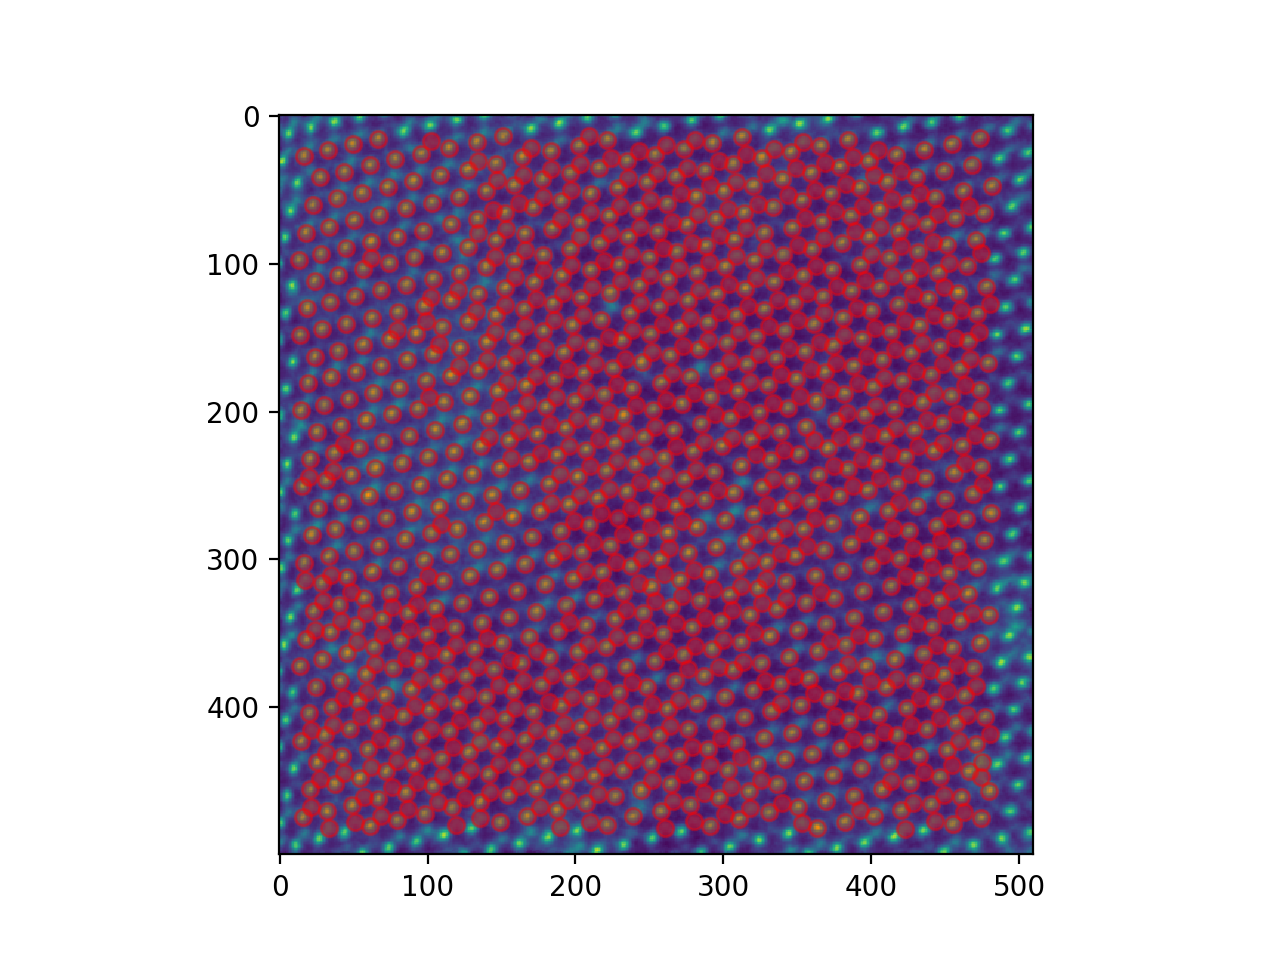

In [35]:

out_tags['radius'] = log_channel['source_size'][()] / log_channel['spatial_scale_x'][()]/2# out_tags['atoms']['source_size']
out_tags['MaxInt'] = 0
out_tags['MinInt'] = 0

sym = atomRefine(data,log_channel['mid_atoms'][()], out_tags)

print(sym.keys())
out_tags2 = {}
out_tags2['radius'] = out_tags['radius']
out_tags2['MaxInt'] = out_tags['MaxInt']
out_tags2['MinInt'] = out_tags['MinInt']

out_tags2.update(sym)

plt.figure()
plt.imshow(data, origin='upper')
plt.scatter(np.array(out_tags2['atoms'])[:,0],np.array(out_tags2['atoms'])[:,1],color='red',alpha=0.4);


## Intensity Histogram

Here we compare two intensity values, the simple sum of the area of the atom (with a round mask) and the amplitude of the Gaussian that we fitted in to the atom blob.


3.5900097006961347
[38.62545653 73.84234265 39.68263902 ... 66.5015388  37.34533427
 64.64934764]
[ 0.          0.75244308  1.50488616  2.25732924  3.00977232  3.7622154
  4.51465848  5.26710156  6.01954464  6.77198771  7.52443079  8.27687387
  9.02931695  9.78176003 10.53420311 11.28664619 12.03908927 12.79153235
 13.54397543 14.29641851 15.04886159 15.80130467 16.55374775 17.30619083
 18.05863391 18.81107699 19.56352007 20.31596314 21.06840622 21.8208493
 22.57329238 23.32573546 24.07817854 24.83062162 25.5830647  26.33550778
 27.08795086 27.84039394 28.59283702 29.3452801  30.09772318 30.85016626
 31.60260934 32.35505242 33.10749549 33.85993857 34.61238165 35.36482473
 36.11726781 36.86971089 37.62215397 38.37459705 39.12704013 39.87948321
 40.63192629 41.38436937 42.13681245 42.88925553 43.64169861 44.39414169
 45.14658477 45.89902785 46.65147092 47.403914   48.15635708 48.90880016
 49.66124324 50.41368632 51.1661294  51.91857248 52.67101556 53.42345864
 54.17590172 54.9283448  55.

<IPython.core.display.Javascript object>


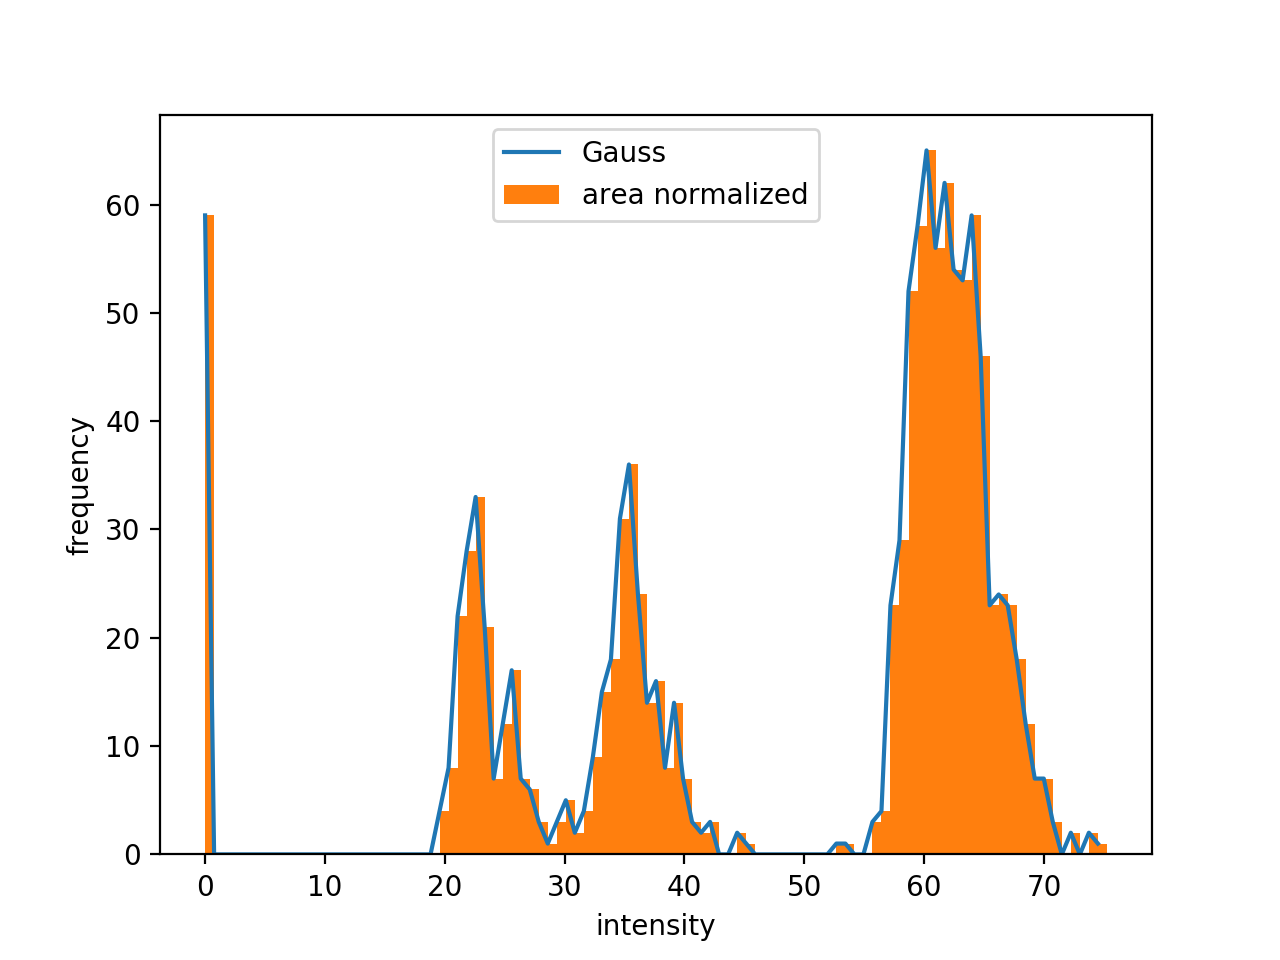

In [37]:
nbins = 100    
print(np.median(out_tags2['Gauss_width']))
Gauss_volume = np.array(out_tags2['Gauss_intensity'])
print(Gauss_volume)
hist_frequency, histo_intensities = np.histogram(Gauss_volume, bins=nbins)
print(histo_intensities)

out_tags2['histogram_intensities'] = histo_intensities
out_tags2['histogram_multiplicity'] = hist_frequency[:-1]
plt.figure()
plt.plot(histo_intensities[:-1],hist_frequency,label='Gauss')
plt.hist(np.array(out_tags2['Gauss_intensity']), bins=nbins, label = 'area normalized');

#plt.hist(np.array(out_tags2['Gauss_amplitude']), bins=nbins, label = 'Gauss');
plt.xlabel('intensity')
plt.ylabel('frequency');
plt.legend();

<IPython.core.display.Javascript object>


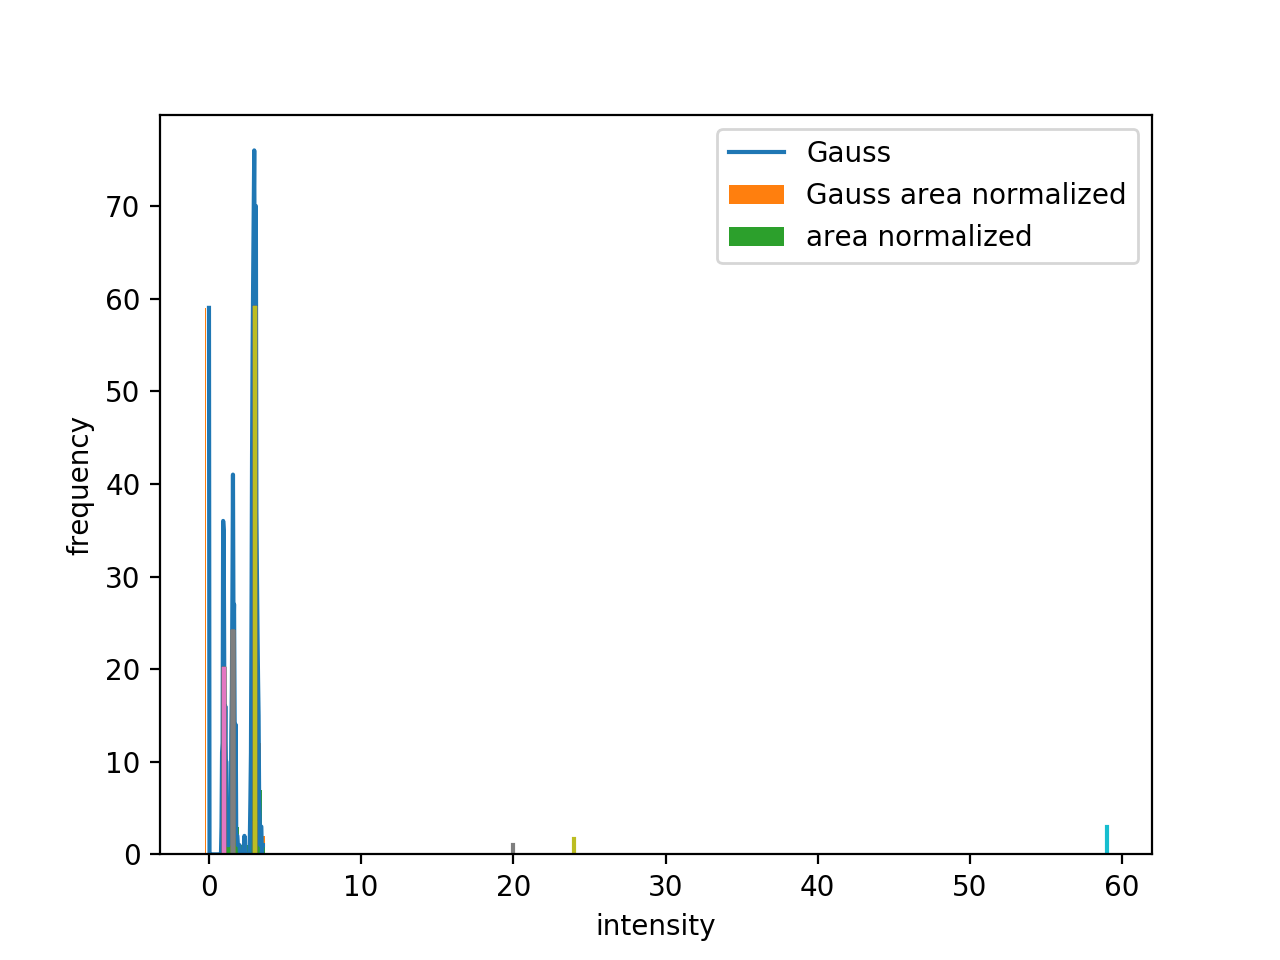

In [50]:
nbins = 100    
histo_frequency, histo_intensities = np.histogram(out_tags2['Gauss_amplitude'], bins=nbins)


out_tags2['histogram_intensities'] = histo_intensities[:-1]
out_tags2['histogram_multiplicity'] = histo_frequency
plt.figure()
plt.plot(histo_intensities[:-1]+0.005,histo_frequency,label='Gauss')
plt.hist(np.array(out_tags2['Gauss_intensity'])/19-.25, bins=nbins, label = 'Gauss area normalized');
plt.hist(np.array(out_tags2['intensity_area'])/19-.25, bins=nbins, label = 'area normalized');

#plt.hist(np.array(out_tags2['Gauss_amplitude']), bins=nbins, label = 'Gauss');
plt.xlabel('intensity')
plt.ylabel('frequency');
plt.legend();

## Fit Histogram

In a Z-contrast image the relative intensity of the atoms is approximatively with the added atomic number **Z** of a monolayer squared. 

here the brightest atom should be tungston (W) with atomic number Z while the other atoms should be two sulfur (2*16) or one sulfur and one selenium atom (16+34 = 2*25).

So first we find the peak positions (with the find_peaks_cwt function in the sipy.signal package) and then we fit Guassians on the histogram.
The peak posiitons give us the relative intensities.

$ I_{relative} = \frac{Z_W^2}{(Z_S+Z_{Se})^2}$
$ I_{relative} = \frac{Z_W^2}{(Z_S+Z_{Se})^2}$


which translate into $ (Z_S+Z_{Se}) = \sqrt{ \frac{Z_W^2}{I_{relative}}}$

peak positions: 0.97, 1.59, 2.98
chalcagenite site average Z: 23.93, 39.36


C:\Users\gduscher\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<IPython.core.display.Javascript object>


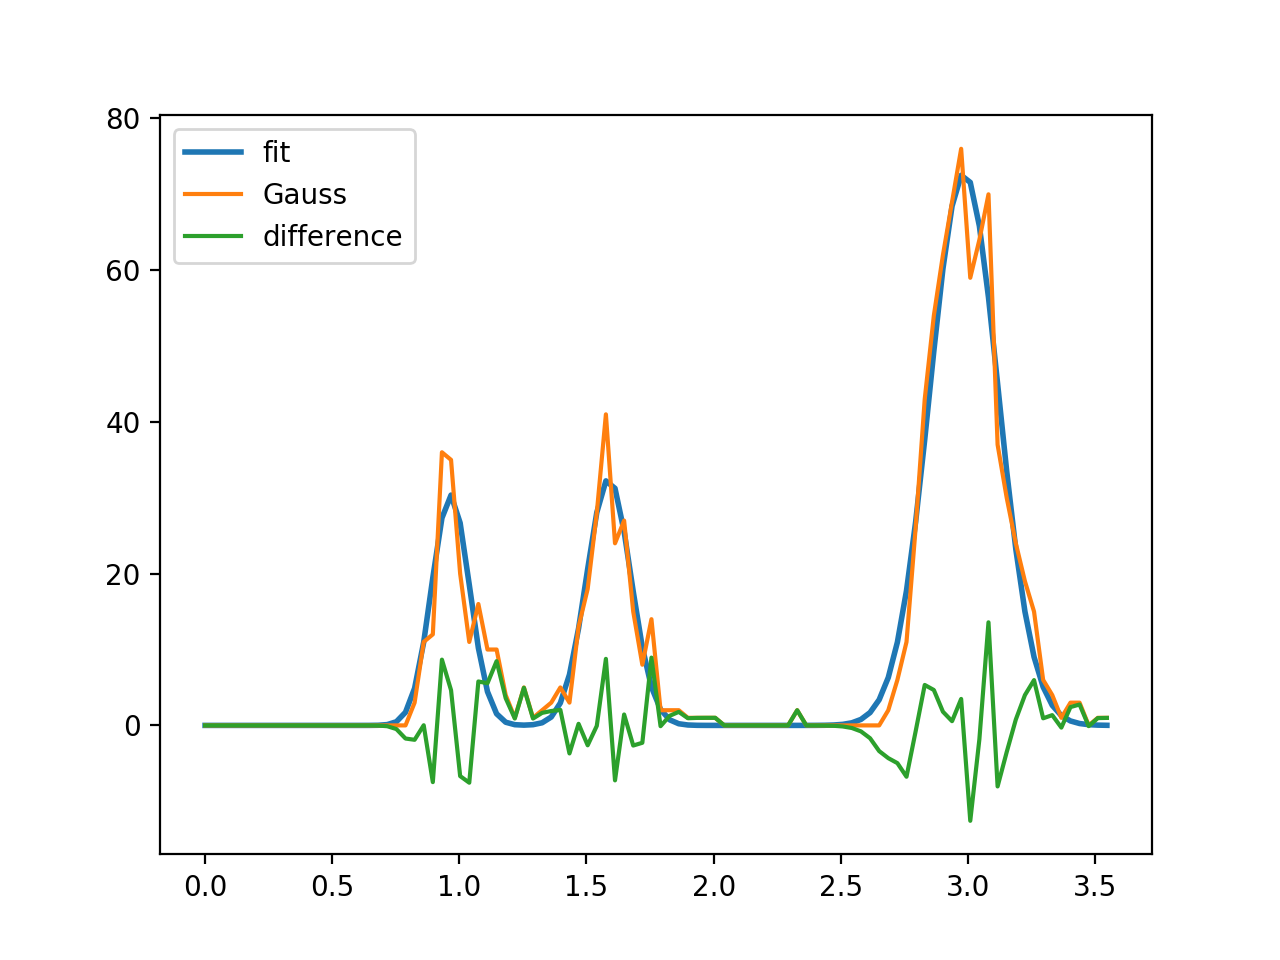

positions: 0.97, 1.59,2.98, 23.9,27.8
27 25.0


In [81]:
from scipy import signal
histo_frequency[0] = 0.
peakind = signal.find_peaks_cwt(histo_frequency, widths= np.arange(5,20))
for i in range(len(peakind)):
    plt.plot([histo_intensities[peakind[i]],histo_intensities[peakind[i]]],[0,histo_frequency[peakind[i]]])
guess = []
for i in range(len(peakind)):
    guess.extend([histo_intensities[peakind[i]],1,.1])
def gauss(x, p): # p[0]==mean, p[1]= area p[2]==fwhm, 
    return p[1] * np.exp(-(x- p[0])**2/(2.0*( p[2]/2.3548)**2))

def model3(x,p):
    y = np.zeros(len(x))
    number_of_peaks = int(len(p)/3)
    for i in range(number_of_peaks):
        y  = y + gauss(x, p[i*3:])
    return y

def residuals3(p, x, y  ):
    err = (y-model3(x,p))#/np.sqrt(np.abs(y))
    return err 
pin = np.array(guess)
p, cov = leastsq(residuals3, guess,  args = (histo_intensities[:-1],histo_frequency) )
#print(p)    
print(f'peak positions: {p[0]:.2f}, {p[3]:.2f}, {p[6]:.2f}')
print(f'chalcagenite site average Z: {np.sqrt(74**2/(p[6]/p[0])**2):.2f}, {np.sqrt(74**2/(p[6]/p[3])**2):.2f}')
    
plt.figure()
plt.plot(histo_intensities[:-1],model3(histo_intensities[:-1],p),label='fit',linewidth = 2)
plt.plot(histo_intensities[:-1],histo_frequency,label='Gauss')
plt.plot(histo_intensities[:-1],histo_frequency-model3(histo_intensities[:-1],p),label='difference')
plt.legend();
print(f'positions: {p[0]:.2f}, {p[3]:.2f},{p[6]:.2f}, {np.sqrt(74**2/(p[6]/p[0])**2):.1f},{np.sqrt(74**2/(p[6]/p[3])**2./2):.1f}')

print(27, (16+34)/2)

C:\Users\gduscher\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


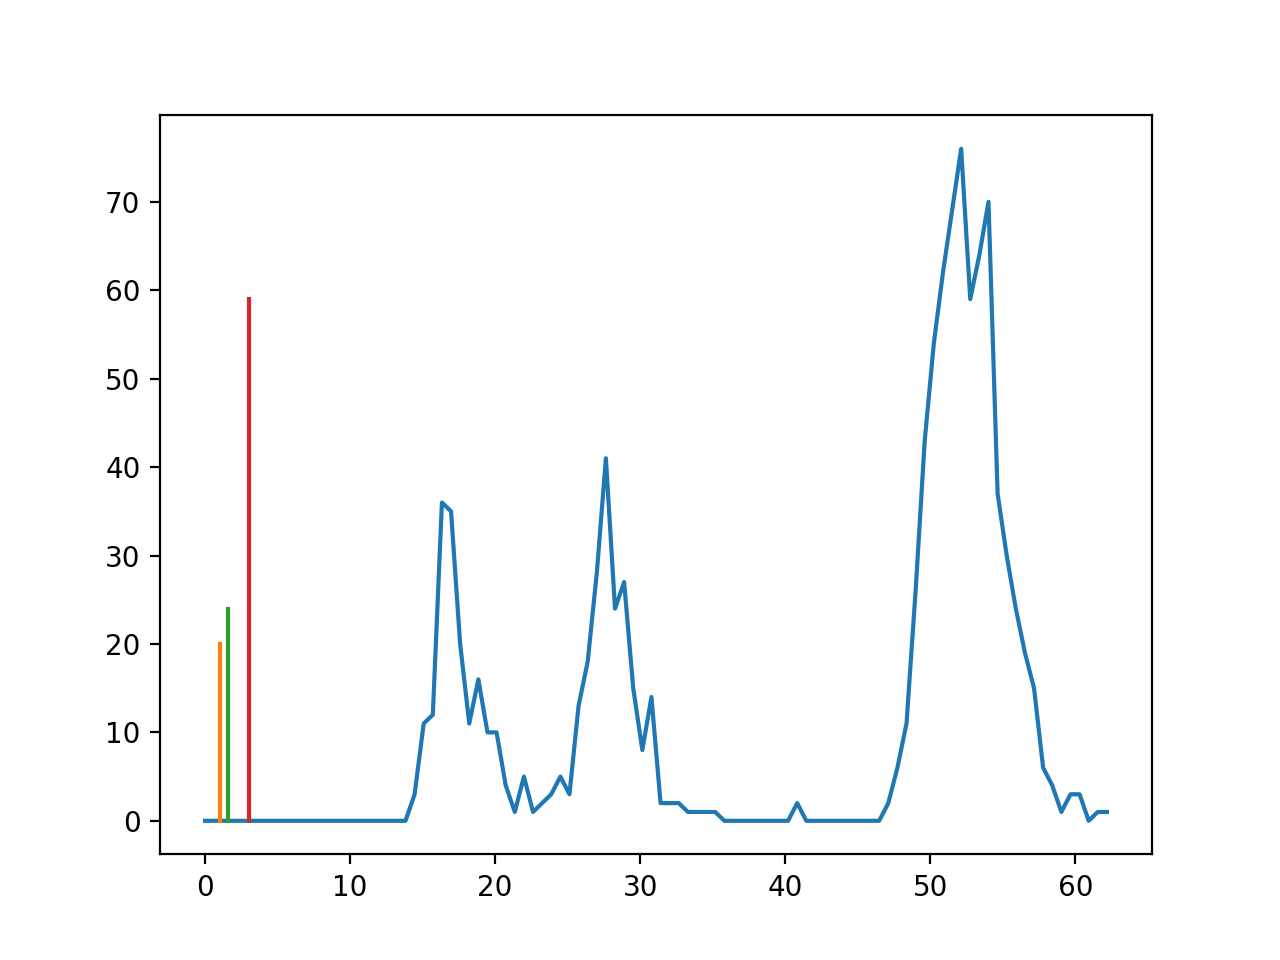

In [80]:
Z = np.sqrt(74**2/(p[6]/histo_intensities[:-1])**2/2)

plt.figure()
plt.plot(Z,histo_frequency,label='Gauss')

392423


<IPython.core.display.Javascript object>


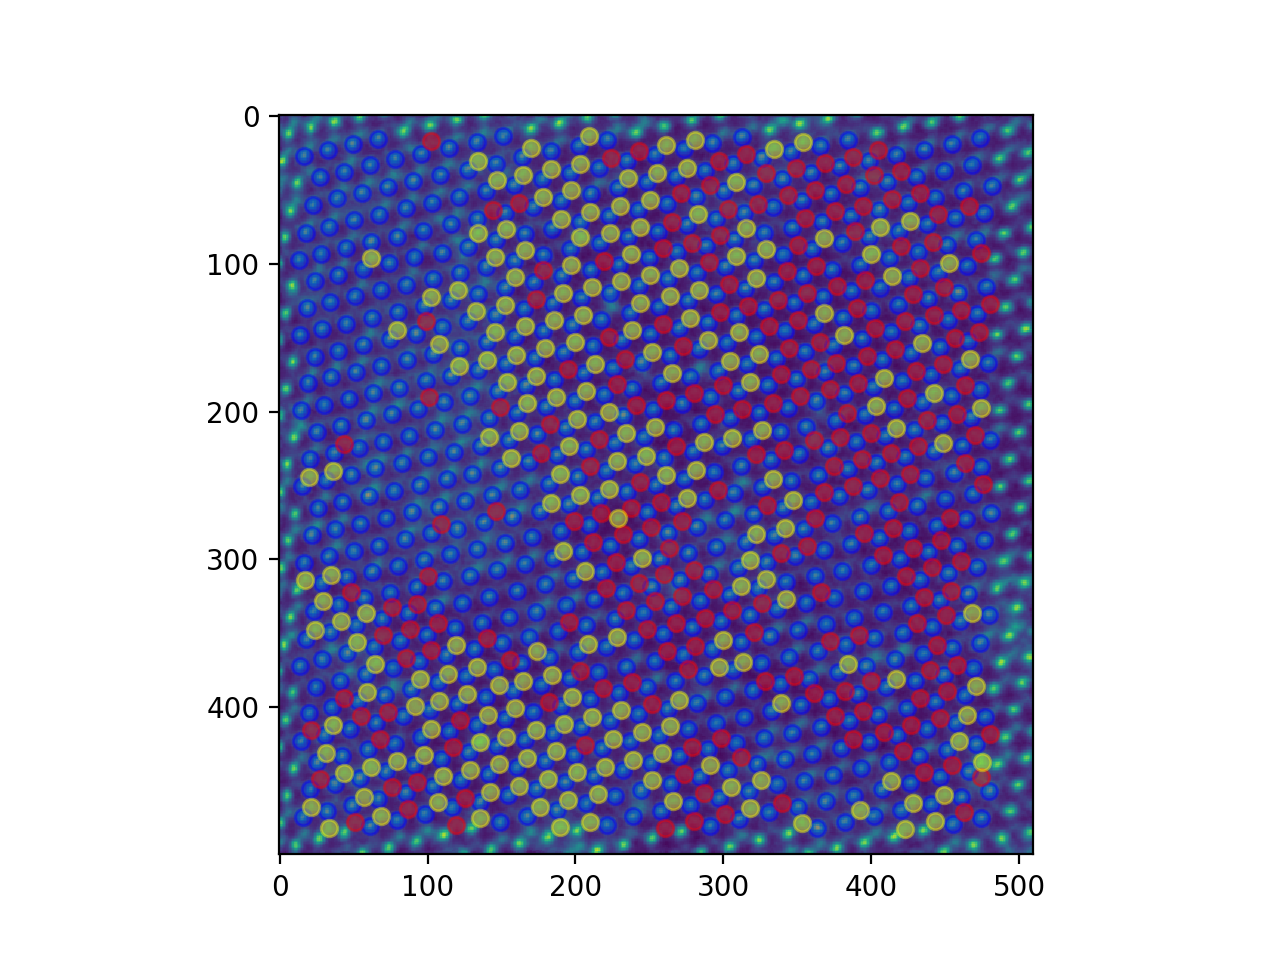

In [272]:
dark = np.where(np.array(out_tags2['Gauss_amplitude'])<1.3)
bright = np.where(np.array(out_tags2['Gauss_amplitude'])>2.5)
medium = np.where(np.logical_and(np.array(out_tags2['Gauss_amplitude'])<2.5, np.array(out_tags2['Gauss_amplitude'])>1.3))
print(np.sum(bright))
plt.figure()
plt.imshow(data, origin='upper')
plt.scatter(np.array(out_tags2['atoms'])[bright,0],np.array(out_tags2['atoms'])[bright,1],color='blue',alpha=0.4);
plt.scatter(np.array(out_tags2['atoms'])[dark,0],np.array(out_tags2['atoms'])[dark,1],color='red',alpha=0.4);
plt.scatter(np.array(out_tags2['atoms'])[medium,0],np.array(out_tags2['atoms'])[medium,1],color='yellow',alpha=0.4);


In [19]:
help(it.atomRefine)
out_tags['radius'] = int(5)# out_tags['atoms']['source_size']
out_tags['MaxInt'] = 0
out_tags['MinInt'] = 0
#print(out_tags['atoms']['mid_atoms'])
a = it.atomRefine(out_tags['reduced_image'], np.array(out_tags['mid_atoms'],dtype=int), out_tags)



Help on function atomRefine in module pyTEMlib.image_tools:

atomRefine(image, atoms, tags, maxDist=2)



C:\Users\gdusc\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:436: RuntimeWarning: Number of calls to function has reached maxfev = 1000.
  warnings.warn(errors[info][0], RuntimeWarning)


NameError: name 'h5_file' is not defined

# Log Atom Refinement

In [213]:

out_tags2['analysis']= 'Atom Position Refinement'
out_tags2['notebook']= __notebook__ 
out_tags2['notebook_version']= __notebook_version__

name = 'Atom refinement'

log_group = ft.h5_add_Log(current_channel, name)

ft.h5_add_Data2Log(log_group, name, out_tags2)

usid.hdf_utils.print_tree(h5_file)




/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ Log_000
      -------
      ├ Rigid_registration_drift
      ├ Rigid_registration_stack
      ├ _rigid_registration
      ├ analysis
      ├ data
      ├ extent
      ├ notebook
      ├ notebook_version
      ├ spatial_origin_x
      ├ spatial_origin_y
      ├ spatial_scale_x
      ├ spatial_scale_y
      ├ spatial_size_x
      ├ spatial_size_y
      ├ spatial_units
      ├ time_stamp
      ├ title
    ├ Log_001
      -------
      ├ Non_Rigid_registration_stack
      ├ _non-rigid_registration
      ├ analysis
      ├ data
      ├ data_type
      ├ extent
      ├ notebook
      ├ notebook_version
      ├ spatial_origin_x
      ├ spatial_origin_y
      ├ spatial_scale_x
      ├ spatial_scale_y
      ├ spatial_size_x
      ├ spatial_size_y
      ├ spatial_units
      ├ time_stamp
      ├ title
    ├ Log_002
      -------
      ├ _Atom finding
      ├ analysis
      ├ atoms
      ├ data
      ├ extent
      ├ imag

In [226]:
h5_file.close()

## Log Ring Graph

## Voronoi Analysis

In [214]:
def voronoi(atoms,im):
    tags = {}
    vor = Voronoi(np.array(atoms)[:,0:2])# Plot it:
    rim_vertices = []
    for i in range(len(vor.vertices)):

        if (vor.vertices[i,0:2]<0).any() or (vor.vertices[i,0:2] > im.shape[0]-5).any():
            rim_vertices.append(i)
    rim_vertices=set(rim_vertices)
    mid_vertices = list(set(np.arange(len(vor.vertices))).difference(rim_vertices))

    mid_regions = []
    for region in vor.regions: #Check all Voronoi polygons
        if all(x in mid_vertices for x in region) and len(region)>1: # we get a lot of rim (-1) and empty and  regions
            mid_regions.append(region)
    tags['voronoi']=vor
    tags['voronoi_vertices']=vor.vertices
    tags['voronoi_regions'] = vor.regions
    tags['voronoi_midVerticesIndices']=mid_vertices
    tags['voronoi_midVertices']=vor.vertices[mid_vertices]
    tags['voronoi_midRegions'] = mid_regions
    return tags


In [215]:
print(out_tags2['atoms'][0])

[422.6537125196703, 482.5261119783037]


<IPython.core.display.Javascript object>


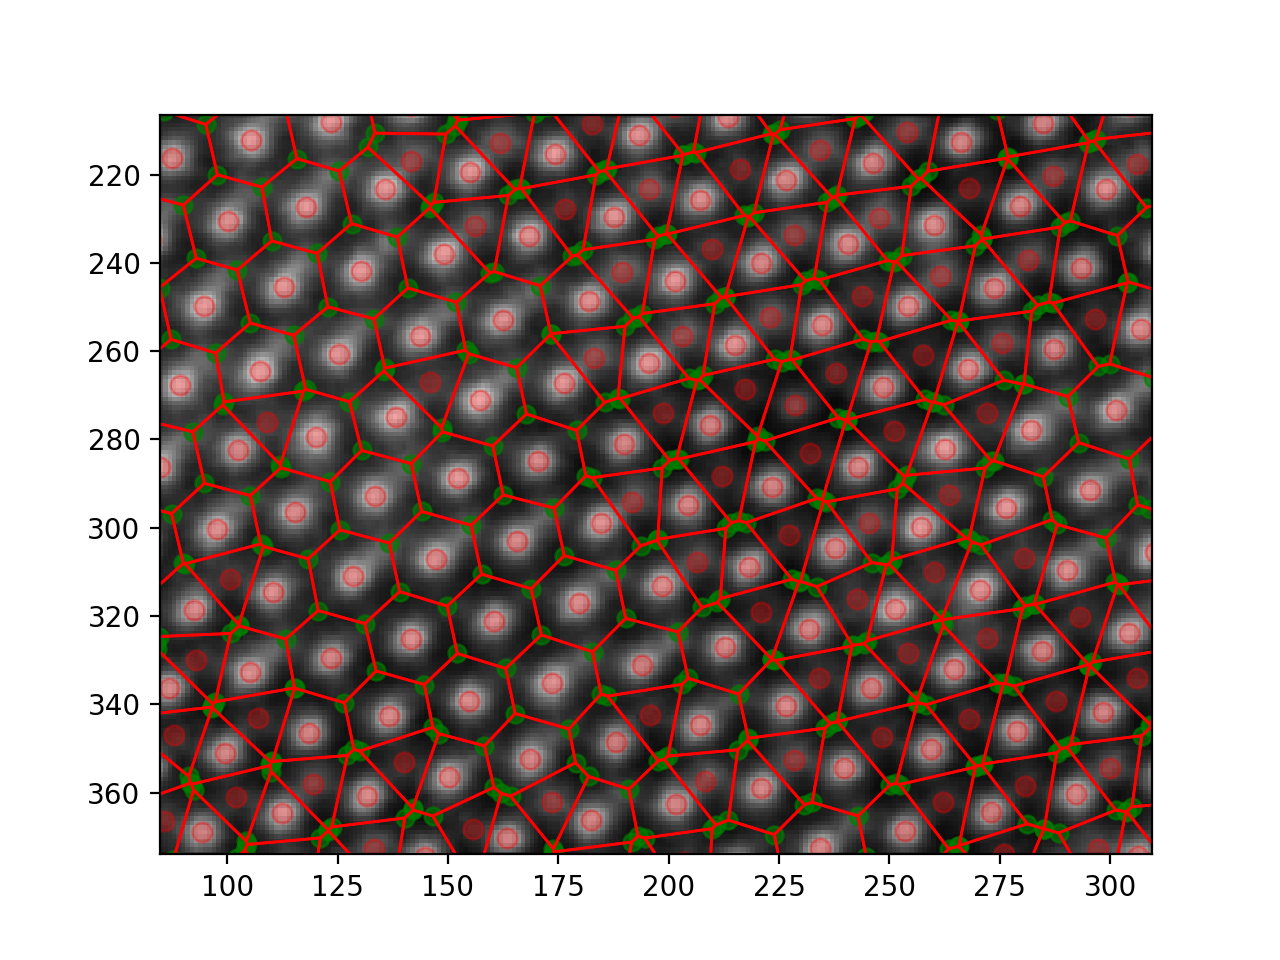

In [218]:
from matplotlib.patches import Polygon
from scipy.spatial import Voronoi, KDTree, cKDTree
out_tags2['atoms'] = np.array(out_tags2['atoms'])

out_tags3 = {}
out_tags3 = voronoi(out_tags2['atoms'], data)


out_tags3['analysis']=f'voronoi'

out_tags3['number_of_voronoi_vertices'] = len(out_tags3['voronoi_midVertices'])

#plotting
fig, ax = plt.subplots()
# plot input points blue
plt.imshow(data, cmap='gray')
#ax.scatter(vor.points[:,0],vor.points[:,1], color = 'b', alpha=0.6, s=40)
plt.scatter(out_tags2['atoms'][:, 0], out_tags2['atoms'][:, 1], color = 'red', s=50, alpha = .3, cmap='jet');

# plot vertices of voronoi tiles in green
ax.scatter(out_tags3['voronoi_midVertices'][:,0], out_tags3['voronoi_midVertices'][:,1], color = 'g', alpha=0.6, s=40)
#plot polygon from vertices


for region in out_tags3['voronoi_midRegions']: #Check all Voronoi polygons
    poly = Polygon( out_tags3['voronoi_vertices'][region,0:2], facecolor='none', edgecolor='r', linewidth = 1)
    ax.add_patch(poly)
               
# ensure pixels are square
ax.set_aspect('equal', 'datalim');

# Graphing

In [224]:
import scipy.spatial as sp
def get_new_vertices(vertices, pointTree):
    """
    Determines the rings in the plot according to planar graph theory
    """
    min_voronoi_distance = 0.95 
    # Define search tree for points and verties
    #pointTree = cKDTree(vor.points)
    vorTree   = cKDTree(vertices)

    nearVerticesIndex = []

    for i , vori in enumerate(vertices):
        pv = pointTree.query(vertices[i],10)
        vv = vorTree.query(vertices[i],10)
        
        pvmin = pv[0][:].min() *min_voronoi_distance # smallest distance of this vertice to any atom
        # Find all vertices that are closer than this nearest atom.
        nn = vorTree.query_ball_point(vori, pvmin)
        
        # Put these vertices in the list
        if len (nearVerticesIndex) == 0:
            nearVerticesIndex.append(nn)
            #print('ring around vertices: ', nn)
        exist = 0
        for j in range(len(nearVerticesIndex)):
            if i in nearVerticesIndex[j]:
                exist = 1
                if len(nn) > len(nearVerticesIndex[j]):
                    nearVerticesIndex[j] = nn
                    
        if exist == 0:
            nearVerticesIndex.append(nn)

    new_voronoi = []       
    # get new vertices by calculating the center of the too close vertices and just keep the single ones
    for ver_ind in  nearVerticesIndex:
        new_ver_point = np.median(vertices[ver_ind], axis=0) # center of all vertices
        new_voronoi.append(new_ver_point.flatten())
    
    return np.array(new_voronoi)
    
def ring_graph(atoms):
    """
    Determines the rings in the plot according to planar graph theory
    """
    
    vor = Voronoi(atoms)
    pointTree = cKDTree(vor.points)
    
    new_voronoi = get_new_vertices(vor.vertices, pointTree)
    #new_voronoi = get_new_vertices(new_voronoi2, pointTree)
    
    vor2 = Voronoi(new_voronoi)
    vor2Tree   = cKDTree(new_voronoi)
    
    # Find rings by doing a vornoi analsis of the new Voronoi vertices
    
    rings = {}
    
    rings['atoms'] = vor.points
    rings['centers'] = new_voronoi
    ring_center = []
    angles_list = []
    positions = []
    atom_indices = []
    cyclicity = []
    ##############################################
    ### Now we find which rings are associated with how many Voronoi vertices
    ##############################################
    print(vor2.points.shape,new_voronoi.shape)
    for i, point in enumerate(vor2.points):
        region_index = vor2.point_region[i] 
        region = vor2.regions[region_index]
        #print(vor2.points[i], vor2.vertices[region])

        #the vertice of the voronoi of a voronoi is the original lattice 
        rings[str(i)] = {}
        rings[str(i)]['center'] = point
        
        vv = vor2Tree.query(new_voronoi[i],10)
        # smallest distance to vertice 
        vertice_min_dist = (vv[0][:])[np.where(vv[0][:]>0)].min() /4 #0 is vertice itself
        
        
        nearest_neighbour_indices = []
        
        if len(region)>1 and (np.array(region)>-1).all():
            for vertice in region:
                dist, nn = pointTree.query(vor2.vertices[vertice], 2)
                if dist[1]-dist[0] < vertice_min_dist/5: #pathological case ()
                    ddd= sp.distance.cdist(vor.points[nn], point[np.newaxis,:])
                    if abs(ddd[1]-ddd[0]) <  vertice_min_dist/20:
                        #add both
                        nearest_neighbour_indices.extend([nn[0]])
                        nearest_neighbour_indices.extend([nn[1]])
                    else:
                        #add closest point
                        if ddd[1] <ddd[0]:
                            nearest_neighbour_indices.extend([nn[1]])
                        else:
                            nearest_neighbour_indices.extend([nn[0]])
                    
                else:
                    nearest_neighbour_indices.extend([nn[0]])
        
            
            
        nn = np.array(np.unique(nearest_neighbour_indices), dtype=int)
        center = np.median(vor.points[nn],axis=0)
        rel_positions =  vor.points[nn]-center
        
        angles = np.arctan2(rel_positions[:,0],rel_positions[:,1])
        ring_order = np.argsort(angles)
        sorted_ring = nn[ring_order]
        
        rings[str(i)]['angles'] = angles[ring_order]
        rings[str(i)]['positions'] = np.array(vor.points[sorted_ring])
        rings[str(i)]['atom_indices'] = sorted_ring
        rings[str(i)]['cyclicity'] = len(angles)
        ring_center.append(np.average(vor.points[sorted_ring], axis=0))
        angles_list.append(angles[ring_order])
        positions.append(vor.points[sorted_ring])
        atom_indices.append(sorted_ring)
        cyclicity.append(len(angles))
    
    rings['ring_centers'] = ring_center
    rings['angles'] = angles_list
    rings['positions'] = positions
    rings['atom_indices'] = atom_indices
    rings['cyclicities'] = cyclicity
    return rings

def plot_voronoi(ax, rings):
    """
    Plots the voronoi vertices and rings of the graph
    """
    
    for i in range(len(rings['centers'])):
        pos = rings['positions'][i]
        if len(pos)>1:

            #for i in range(-1,len(pos)-1):
            #    ax.plot((pos[i][0],pos[i+1][0]),(pos[i][1],pos[i+1][1]),color='blue')

            col = 'gray'
            cyclicity = rings['cyclicities'][i]
            if cyclicity == 4:
                col = 'black'
            elif cyclicity == 5:
                col = 'g'
            elif cyclicity == 6:
                col = 'r'   
            elif cyclicity > 6:
                col = 'blue'    

            ax.add_patch(Polygon(pos, closed=True,fill=True,alpha = 0.2,edgecolor = 'black',facecolor = col,linewidth = .9))
            
    # plot input points blue
    ax.scatter(rings['atoms'][:,0],rings['atoms'][:,1], color = 'b', alpha=0.6, s=40)
    ax.scatter(rings['centers'][:,0],rings['centers'][:,1], color = 'orange', alpha=0.6, s=20)
    #ax.scatter(rings['vertices2'][:,0],rings['vertices2'][:,1], color = 'red', alpha=0.6, s=20)
    
    # ensure pixels are square
    ax.set_aspect('equal', 'datalim');
    
    




(762, 2) (762, 2)


C:\Users\gduscher\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\gduscher\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\Users\gduscher\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\function_base.py:356: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)


<IPython.core.display.Javascript object>


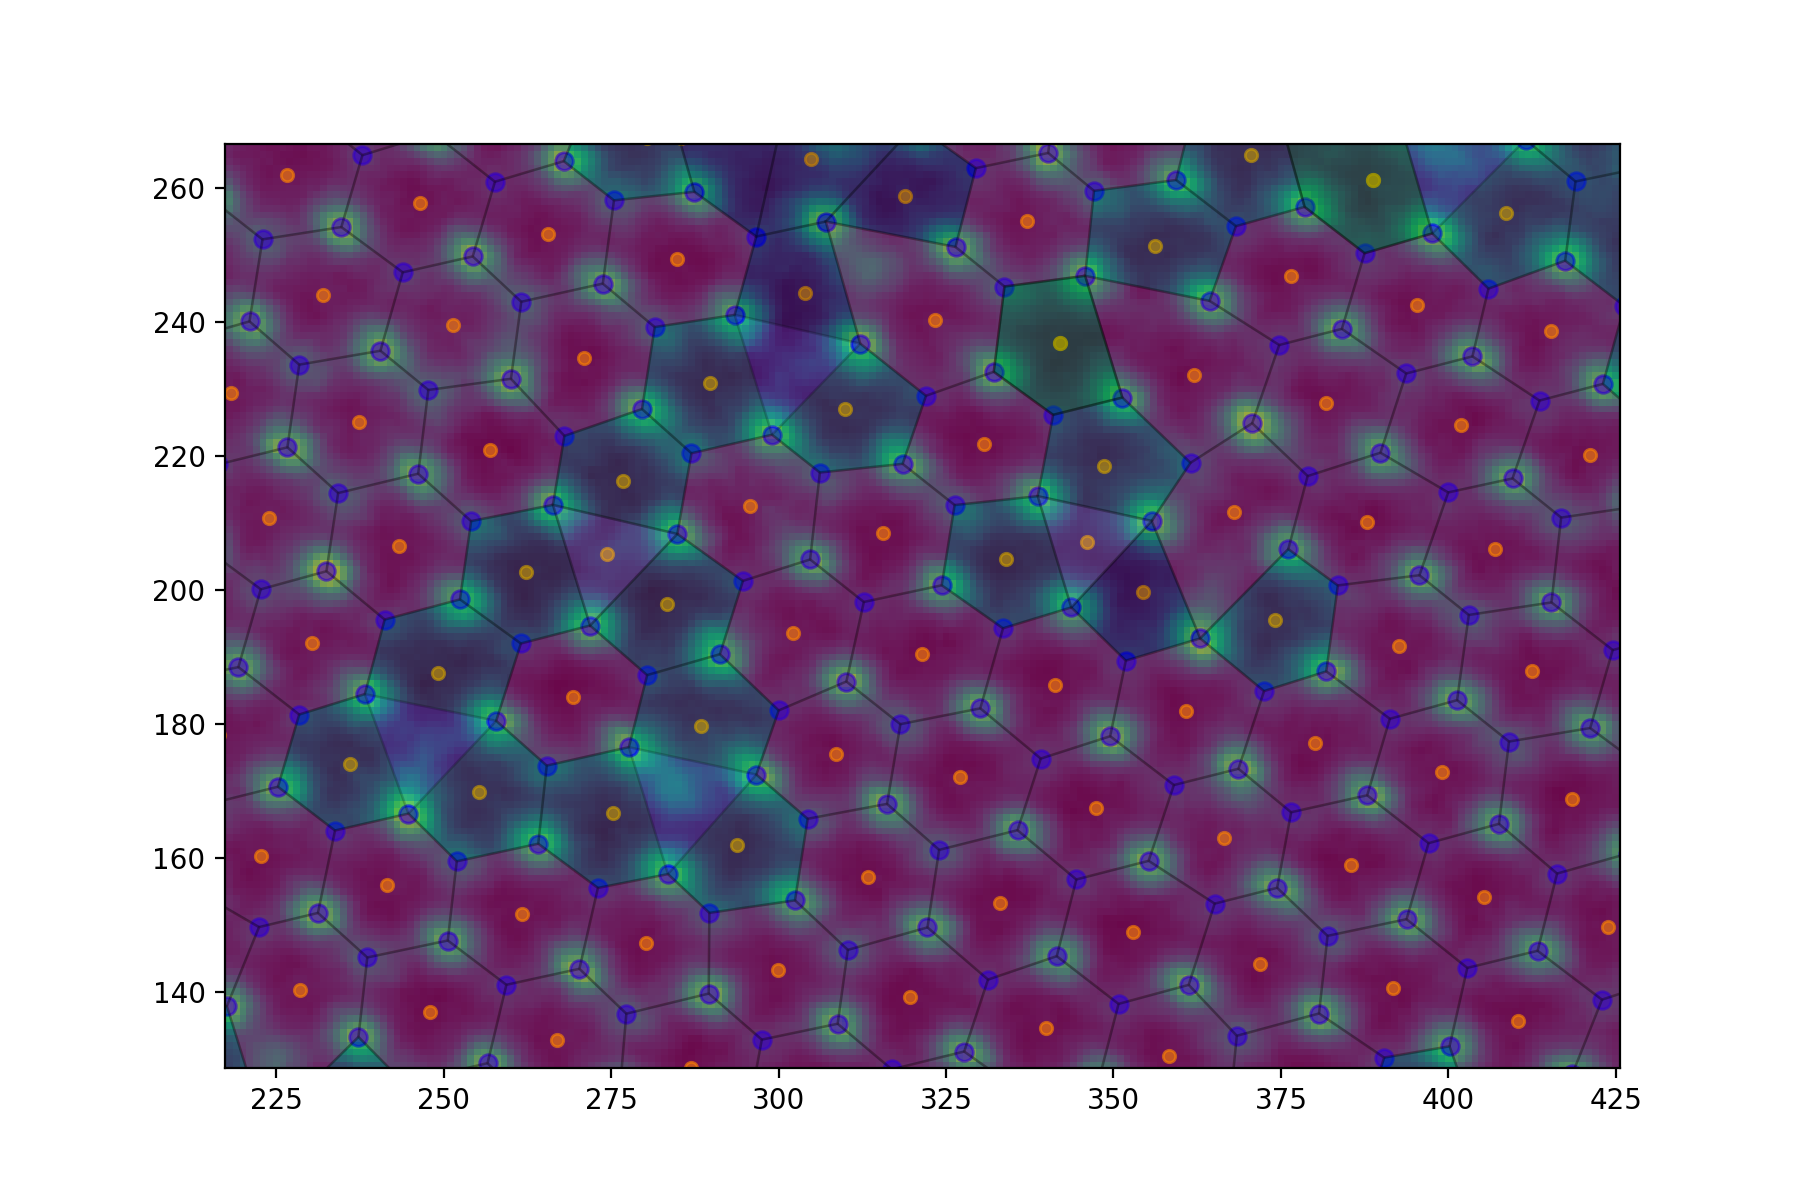

In [225]:

rings = ring_graph(out_tags2['atoms'])

out_tags4 = {}
out_tags4['analysis'] = 'graph'
out_tags4['atoms'] = rings['atoms'] 
out_tags4['centers'] = rings['centers'] 
out_tags4['ring_centers'] = np.array(rings['ring_centers']) 
out_tags4['angles'] = rings['angles']
out_tags4['positions'] = rings['positions']
out_tags4['atom_indices'] = rings['atom_indices']
out_tags4['cyclicities'] = rings['cyclicities']

fig, ax = plt.subplots(1,1,figsize=(9,6))
ax.imshow(data)
ax.set_xlim(0,data.shape[0])

ax.set_ylim(0,data.shape[1])
plot_voronoi(ax, out_tags4)   

#ax.scatter(rings['ring_centers'][:,0],rings['ring_centers'][:,1], color = 'orange', alpha=0.6, s=20)

In [320]:
out_tags2['analysis']= 'Ring Graph'

name = 'Ring Graph'

log_group = ft.h5_add_Log(current_channel, name)

ft.h5_add_Data2Log(log_group, name, out_tags2)

usid.hdf_utils.print_tree(h5_file)

/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ Log_000
      -------
      ├ Rigid_registration_drift
      ├ Rigid_registration_stack
      ├ Rigid_registration_sum
      ├ _rigid_registration
      ├ analysis
      ├ data
      ├ extent
      ├ spatial_origin_x
      ├ spatial_origin_y
      ├ spatial_scale_x
      ├ spatial_scale_y
      ├ spatial_size_x
      ├ spatial_size_y
      ├ spatial_units
      ├ time_stamp
      ├ title
    ├ Log_001
      -------
      ├ _atom finding
      ├ analysis
      ├ atoms
      ├ extent
      ├ image
      ├ mid_atoms
      ├ nearest_neighbours
      ├ number_of_atoms
      ├ number_of_evaluated_atoms
      ├ pixel_size
      ├ reduced_image
      ├ rel_blob_size
      ├ rim_atoms
      ├ rim_size
      ├ source_size
      ├ spatial_origin_x
      ├ spatial_origin_y
      ├ spatial_scale_x
      ├ spatial_scale_y
      ├ spatial_size_x
      ├ spatial_size_y
      ├ spatial_units
      ├ threshold
      ├ time_stamp

In [319]:
#del current_channel['Log_002']
usid.hdf_utils.print_tree(h5_file)

/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ Log_000
      -------
      ├ Rigid_registration_drift
      ├ Rigid_registration_stack
      ├ Rigid_registration_sum
      ├ _rigid_registration
      ├ analysis
      ├ data
      ├ extent
      ├ spatial_origin_x
      ├ spatial_origin_y
      ├ spatial_scale_x
      ├ spatial_scale_y
      ├ spatial_size_x
      ├ spatial_size_y
      ├ spatial_units
      ├ time_stamp
      ├ title
    ├ Log_001
      -------
      ├ _atom finding
      ├ analysis
      ├ atoms
      ├ extent
      ├ image
      ├ mid_atoms
      ├ nearest_neighbours
      ├ number_of_atoms
      ├ number_of_evaluated_atoms
      ├ pixel_size
      ├ reduced_image
      ├ rel_blob_size
      ├ rim_atoms
      ├ rim_size
      ├ source_size
      ├ spatial_origin_x
      ├ spatial_origin_y
      ├ spatial_scale_x
      ├ spatial_scale_y
      ├ spatial_size_x
      ├ spatial_size_y
      ├ spatial_units
      ├ threshold
      ├ time_stamp

dict_keys(['analysis', 'atoms', 'centers', 'ring_centers', 'angles', 'positions', 'atom_indices', 'cyclicities'])
dict_keys(['radius', 'MaxInt', 'MinInt', 'number_of_atoms', 'atoms', 'x', 'y', 'Z', 'Column', 'position', 'intensity_area', 'maximum_area', 'Gauss_width', 'Gauss_amplitude', 'Gauss_volume', 'analysis'])
269.9287 15.414983
a0 -1.8617022305056081 -109.59300689766026 0.4143883258589862
a1 0.10450944016516617 12.413217400320802 0.45973474225554983
a2 2.166846996897949 134.64078808723275 0.5654435970429511
152.79602 42.319145


<IPython.core.display.Javascript object>


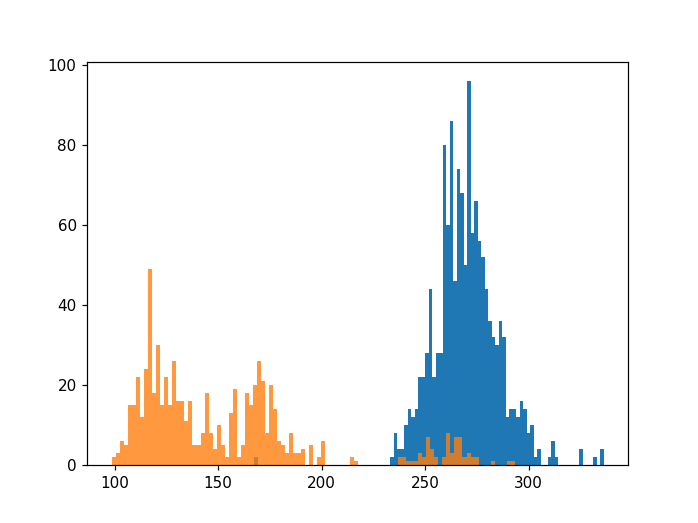

(array([ 2.,  3.,  6.,  5., 15., 15., 22., 12., 24., 49., 18., 30., 15.,
        22., 15., 26., 16., 16., 11., 16.,  5.,  5.,  8., 18.,  8.,  4.,
        10.,  5.,  2., 13., 19.,  2.,  5., 18., 15., 20., 26., 21.,  8.,
        20., 14.,  6.,  5.,  3.,  8.,  3.,  3.,  4.,  0.,  5.,  0.,  2.,
         6.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  2.,  2.,  1.,  1.,  1.,  3.,  2.,
         7.,  4.,  2.,  0.,  2.,  8.,  3.,  7.,  7.,  2.,  3.,  2.,  2.,
         0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  1.]),
 array([ 98.682724, 100.62942 , 102.57611 , 104.52281 , 106.469505,
        108.4162  , 110.36289 , 112.30959 , 114.25629 , 116.20298 ,
        118.14967 , 120.09637 , 122.04307 , 123.98976 , 125.936455,
        127.88315 , 129.82985 , 131.77654 , 133.72324 , 135.66994 ,
        137.61662 , 139.56332 , 141.51001 , 143.45671 , 145.40341 ,
        147.3501  , 149.2968  , 151.24348 , 153.19019 , 155.13689 ,
        157.08357 , 159.03

In [363]:
print(out_tags4.keys())
print(out_tags2.keys())
#print(ring['102'])
#print(out_tags['atoms']['voronoi'].points[666])
#print(sym[str(666)])
bright = []
angle = []
angle2 = []
angle3 = []
dimm=[]
ring_intensities = []
for rindex in range(len(rings['centers'])):
    intensity = []
    for ind in rings['atom_indices'][rindex]:
        index = int(ind)
        if str(index) in sym:
            intensity.append(sym[str(index)]['intensity area'])
    rings[str(rindex)]['intensity']=intensity
    ring_intensities.append(intensity)
    if rings[str(rindex)]['cyclicity'] == 6:
        intensity = np.array(intensity)
        index_by_intensity = np.array(np.argsort(intensity),dtype=int)
        bright.extend(intensity[index_by_intensity[3:6]])
        a = np.array(rings['angles'][rindex])
        aa = np.sort(a[index_by_intensity[3:6]] )
        
        angle.append(aa[0])
        angle2.append(aa[1])
        angle3.append(aa[2])
        bright.extend(np.sort(intensity)[3:6])
        dimm.extend(np.sort(intensity)[0:3])
        
print(np.mean(bright), np.std(bright))
print('a0', np.mean(angle), np.degrees(np.median(angle)), np.std(angle))
print('a1', np.mean(angle2), np.degrees(np.median(angle2)), np.std(angle2))
print('a2', np.mean(angle3), np.degrees(np.median(angle3)), np.std(angle3))
print(np.mean(dimm),np.std(dimm))

plt.figure()
plt.hist(bright, 100, alpha = 1)
plt.hist(dimm, 100, alpha = 0.8)

<IPython.core.display.Javascript object>


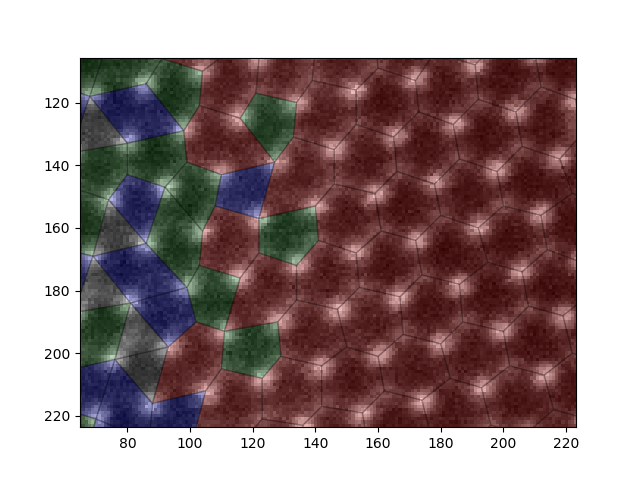

In [14]:
ring = out_tags['atoms']['ring']
fig = plt.figure()
plt.imshow(out_tags['image'] ,cmap='gray')

for i in range(len(ring)):
    col = 'gray'
    if ring[str(i)]['cyclicity'] == 4:
        col = 'blue'
    elif ring[str(i)]['cyclicity'] == 5:
        col = 'g'
    elif ring[str(i)]['cyclicity'] == 6:
        col = 'r'   
       
    elif ring[str(i)]['cyclicity'] > 6:
        col = 'black'    
        
    plt.gca().add_patch(Polygon(ring[str(i)]['points'], closed=True,fill=True,alpha = 0.2,edgecolor = 'black',facecolor = col,linewidth = 1))


#plt.scatter(out_tags['atoms']['mid_atoms'][:, 0], out_tags['atoms']['mid_atoms'][:, 1], c=out_tags['atoms']['clusters'], s=20, alpha = .5, cmap='jet');


plt.gca().set_aspect('equal', 'datalim');


In [321]:
from scipy.spatial import Voronoi, KDTree, cKDTree
print(ring['102']['point_indices'])
#ring = Graph(out_tags['atoms']['voronoi'],out_tags, 0.9)
print(ring['102'])

print(sym[str(661)])
print(out_tags['atoms']['voronoi'].points[678])

print(np.cos(np.radians(ring['102']['angles'])))
print(np.sin(np.radians(ring['102']['angles'])))

NameError: name 'ring' is not defined

In [118]:
vor = Voronoi(np.array(atoms)[:,0:2])# Plot it:
sizeX = 512
rim_vertices = []
for i in range(len(vor.vertices)):

    if (vor.vertices[i,0:2]<0).any() or (vor.vertices[i,0:2] > sizeX-5).any():
        rim_vertices.append(i)
rim_vertices = np.unique(rim_vertices)
mid_vertices = np.arange(len(vor.vertices))
print(rim_vertices)
mid_vertices = np.setdiff1d(np.arange(len(vor.vertices)),rim_vertices)#mid_vertices[! rim_vertices]
print(mid_vertices)

[   1    2    3    4    6    8   10   18   23   24   70   71   89   90
  130  153  154  157  214  215  216  226  249  402  471  472  487  489
  491  511  592  593  607  657  658  664  668  673  686  689  755  832
  837  896  898  899  912  913  927  928 1053 1113 1114 1231 1243 1244
 1247 1323 1324 1379 1382 1632 1633 1660 1661 1863 1875 1922 1954 2491
 2492 2540 2541 2550 2571 2717 2852 2991 2999 3138 3150 3166 3175 3335
 3362 3397 3645 3779 3782 3783 3875 3880 4010 4230]
[   0    5    7 ... 4472 4473 4474]


In [20]:
from scipy.spatial import Voronoi, KDTree, cKDTree
def voronoi(atoms,sizeX):
    
    vor = Voronoi(np.array(atoms)[:,0:2])# Plot it:
    rim_vertices = []
    for i in range(len(vor.vertices)):

        if (vor.vertices[i,0:2]<0).any() or (vor.vertices[i,0:2] > sizeX-5).any():
            rim_vertices.append(i)
    rim_vertices = np.unique(rim_vertices)
    mid_vertices = np.setdiff1d(np.arange(len(vor.vertices)),rim_vertices)

    mid_regions = []
    for region in vor.regions: #Check all Voronoi polygons
        if all(x in mid_vertices for x in region) and len(region)>1: # we get a lot of rim (-1) and empty and  regions
            mid_regions.append(region)
    tags = {}
    tags['voronoi']=vor
    tags['voronoi_vertices']=vor.vertices
    tags['voronoi_regions'] = vor.regions
    tags['voronoi_midVerticesIndices']=mid_vertices
    tags['voronoi_midVertices']=vor.vertices[mid_vertices]
    tags['voronoi_midRegions'] = mid_regions
    return tags
    
def Graph(atoms,out_tags, min_vor=1., verbose = False):
    
    im = out_tags['image']
    sizeX = np.array(im.shape).min()
    
    vor_tags = voronoi(atoms, sizeX)
    
    vor = vor_tags['voronoi']
    
    pointTree = KDTree(vor.points)
    vorTree   = KDTree(vor.vertices)

    nearVerticesIndex = []

    
    

    for i , vori in enumerate(vor.vertices):
        if i in vor_tags['voronoi_midVerticesIndices']:#mid_vertices:
            pv = pointTree.query(vor.vertices[i],10)
            vv = vorTree.query(vor.vertices[i],10)

            pvmin = pv[0][:].min()*min_vor
            #print(pvmin)
            nn = vorTree.query_ball_point(vori, pvmin)
            if len (nearVerticesIndex) == 0:
                nearVerticesIndex.append(nn)
                if verbose:
                    print('ring around vertices: ', nn)
            exist = 0
            for j in range(len(nearVerticesIndex)):
                if i in nearVerticesIndex[j]:
                    exist = 1
                    if len(nn) > len(nearVerticesIndex[j]):
                        nearVerticesIndex[j] = nn
                        if verbose:
                            print('corrected ring around vertices: ', nn)
            if exist == 0:
                nearVerticesIndex.append(nn)

    nw_vertices = []
    for ver in nearVerticesIndex:
        nw_vertices.append([vor.vertices[ver,0].sum()/len(ver), vor.vertices[ver,1].sum()/len(ver)])
    
    pointTree = KDTree(np.array(out_tags['atoms']['atoms'])[:,0:2])

    vor2 = Voronoi(nw_vertices)# Plot it:

    rim_vertices = []
    for i in range(len(vor2.vertices)):

        if (vor2.vertices[i,0:2]<0).any() or (vor2.vertices[i,0:2] > im.shape[0]-5).any():
            rim_vertices.append(i)
    rim_vertices=set(rim_vertices)
    mid_vertices = list(set(np.arange(len(vor.vertices))).difference(rim_vertices))

    mid_regions = []
    for region in vor2.regions: #Check all Voronoi polygons
        if all(x in mid_vertices for x in region) and len(region)>1: # we get a lot of rim (-1) and empty and  regions
            mid_regions.append(region)

    regions2 = []
    vertices2 = []
    ring= {}
    #fig = plt.figure()
    #plt.imshow(im ,cmap='gray')
    #plt.scatter(np.array(nw_vertices)[:, 0], np.array(nw_vertices)[:, 1], c='r', s=20, alpha = .5, cmap='jet');
    ind =0

    #plt.scatter(np.array(mid_atoms)[:, 0], np.array(mid_atoms)[:, 1], c='b', s=20, alpha = .5, cmap='jet');

    for i, region in enumerate(mid_regions): #Check all Voronoi polygons
        if all(x >0 for x in region) and len(region)>1: # we get a lot of rim (-1) and empty and  regions

            regions2.append(region)
            verts = vor2.vertices[region]
            indices_points = []#np.zeros(len(region),dtype = int)


            for j in range(len(verts)):
                d,pv = pointTree.query(verts[j],k=1) # return nearest neighbour (1) to vert    
                verts[j] = pointTree.data[pv]
                indices_points.append(pv)
                
            _, idx = np.unique(verts, return_index=True,axis = 0)
            verts = verts[np.array(np.sort(idx),dtype=int),:]
            indices_points = np.array(indices_points, dtype=int)[np.array(np.sort(idx),dtype=int)]
            
            vertices2.append(verts)

            rr =2
            
            ring[str(i)] = {}
            ring[str(i)]['center']  = np.array(np.mean(verts, axis=0),dtype=int)
            cx,cy = ring[str(i)]['center']
            area = im[cx-rr:cx+rr+1,cy-rr:cy+rr+1]
            center_intensity = area.sum()
            ring[str(i)]['center_intensity']=area.sum()
            
            areas = []
            angles = []
            for j in range(len(verts)):
                x, y = np.array(verts[j],dtype=int)
                areas.append(im[x-rr:x+rr+1,y-rr:y+rr+1].sum())
                angles.append(np.arctan2(x-cx, y-cy) +np.pi% (2.0 * np.pi))
            indices = np.argsort(angles)
            ring[str(i)]['atom_intensities']=np.array(areas)[indices]
            ring[str(i)]['atom_angles']=np.array(angles)[indices]
            ring[str(i)]['points']=np.array(verts)[indices]
            ring[str(i)]['cyclicity'] = verts.shape[0]
            ring[str(i)]['point_indices']=np.array(indices_points)[indices]


            #poly = Polygon(verts, facecolor='none', edgecolor='r', linewidth = 1)
            #plt.gca().add_patch(poly)
            ind+=1
            

    plt.show()  
    return ring

In [21]:
ring = Graph(out_tags['atoms']['atoms'],out_tags, 0.9)

In [22]:

bright = []
mean_angle = []
    
for key in (ring):
   
    try:
        i = int(key)
    except:
        i = 0
    if ring[str(i)]['cyclicity'] == 6:
        angles = np.rad2deg(ring[str(i)]['atom_angles'])
        angles = np.append(angles,angles[0]+360)
        mean_angle.append(np.mean(np.diff(angles)))
        #print(np.sin(ring[str(i)]['atom_angles']))
        
        intensity_indices = np.argsort(ring[str(i)]['atom_intensities'])
        
        bright_atoms =  intensity_indices[3:6]
        #print(ring[str(i)]['atom_intensities'][intensity_indices])
        bright2=(angles[bright_atoms].min())
        
        if abs(bright2-60)<5:
            bright.append(angles[bright_atoms].min())
            
        ind = np.argwhere((np.abs(angles[bright_atoms]-60)<5))
        if len(ind)>0:
            print(ring[str(i)]['points'][ind])
        
print(np.median(bright))

[[[116. 176.]]]
[[[417. 249.]]]
[[[ 74. 100.]]]
[[[105. 212.]]]
[[[ 85. 286.]]]
[[[118. 227.]]]
[[[354. 410.]]]
[[[344. 326.]]]
[[[ 86. 165.]]]
[[[ 93. 198.]]]
60.94539590092286


In [179]:
fig = plt.figure()
plt.imshow(out_tags['image'] ,cmap='gray')
atoms = out_tags['atoms']['atoms']
for i in range(len(ring)):
    col = 'gray'
    if ring[str(i)]['cyclicity'] == 4:
        col = 'blue'
    elif ring[str(i)]['cyclicity'] == 5:
        col = 'g'
    elif ring[str(i)]['cyclicity'] == 6:
        col = 'r'   
       
    elif ring[str(i)]['cyclicity'] > 6:
        col = 'black'    
    ind = list(np.array(ring[str(i)]['point_indices']).flatten())
    corners= [atoms[i][0:2] for i in ring[str(i)]['point_indices']]
    
    
    plt.gca().add_patch(Polygon(corners, closed=True,fill=True,alpha = 0.2,edgecolor = 'black',facecolor = col,linewidth = 1))
    

#plt.scatter(out_tags['atoms']['mid_atoms'][:, 0], out_tags['atoms']['mid_atoms'][:, 1], c=out_tags['atoms']['clusters'], s=20, alpha = .5, cmap='jet');

plt.gca().set_aspect('equal', 'datalim');



<IPython.core.display.Javascript object>

KeyError: '1171'

In [108]:


print(ring['102']['point_indices'])
print(ring['102']['points'])
#ring = Graph(out_tags['atoms']['voronoi'],out_tags, 0.9)
#print(ring['102'])

print(sym[str(661)])
print(out_tags['atoms']['voronoi'].points[661])
for i in ring['102']['point_indices']:
    print('b',i, out_tags['atoms']['atoms'][i])
    print('s', sym[str(i)])
print(np.cos(np.radians(ring['102']['angles'])))
print(np.sin(np.radians(ring['102']['angles'])))

[721, 678, 661, 685, 726, 743, 743]
[[154. 362.]
 [146. 366.]
 [138. 360.]
 [139. 351.]
 [147. 346.]
 [155. 352.]]
{'index': 661, 'x': 352.0, 'y': 345.0, 'Z': 0, 'Name': 'undefined', 'Column': -1, 'position': 'inside', 'intensity area': 12.615764, 'maximum area': 0.74528897, 'Gauss width': 0.0, 'Gauss amplitude': 0.0, 'Gauss volume': 0.0}
[352. 345.]
b 721 [155.0, 352.0, 1.6]
s {'index': 721, 'x': 154.2646330648168, 'y': 329.344577936209, 'Z': 0, 'Name': 'undefined', 'Column': -1, 'position': 'inside', 'intensity area': 13.626804, 'maximum area': 0.5348534, 'Gauss width': 6.138800815702884, 'Gauss amplitude': 0.5262375120653247, 'Gauss volume': 124.60307368784818}
b 678 [154.0, 362.0, 1.6]
s {'index': 678, 'x': 83.0, 'y': 341.0, 'Z': 0, 'Name': 'undefined', 'Column': -1, 'position': 'inside', 'intensity area': 12.634991, 'maximum area': 0.6352461, 'Gauss width': 0.0, 'Gauss amplitude': 0.0, 'Gauss volume': 0.0}
b 661 [146.0, 366.0, 1.6]
s {'index': 661, 'x': 352.0, 'y': 345.0, 'Z': 0, 